# Case 2: Analysis of Brazilian Products Import and Export in Python

## Importing the libraries and setting up the environment:

In [1]:
import torch

import os
import csv
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Use white grid plot background from seaborn
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
plt.style.use('seaborn-white')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data exploration

Let's load the data and have a peek:

In [2]:
path = os.getcwd()
path

'/Users/robertomartins/Desktop/Challenge_4i'

In [3]:
os.chdir(path)

In [4]:
df = pd.read_csv('data_comexstat.csv', encoding='latin-1', parse_dates=['date'], date_parser=lambda t: dt.datetime.strptime(t, '%Y-%m-%d').date())
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [5]:
df.columns

Index(['date', 'product', 'state', 'country', 'type', 'route', 'tons', 'usd'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117965 entries, 0 to 117964
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     117965 non-null  datetime64[ns]
 1   product  117965 non-null  object        
 2   state    117965 non-null  object        
 3   country  117965 non-null  object        
 4   type     117965 non-null  object        
 5   route    117965 non-null  object        
 6   tons     117965 non-null  float64       
 7   usd      117965 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 7.2+ MB


In [7]:
df.describe()

,tons,usd
count,1.179650e+05,1.179650e+05
mean,1.453681e+04,4.813150e+06
std,4.977926e+04,1.949412e+07
min,0.000000e+00,0.000000e+00
25%,1.249000e+02,7.155200e+04
50%,2.000000e+03,7.250000e+05
75%,1.353403e+04,3.895943e+06
max,1.798446e+06,9.039304e+08


In [8]:
df['product'].unique()

array(['corn', 'soybean_meal', 'soybean_oil', 'soybeans', 'sugar',
       'wheat'], dtype=object)

In [9]:
df['type'].unique()

array(['Import', 'Export'], dtype=object)

In [10]:
df['route'].unique()

array(['Sea', 'Ground', 'Air', 'Other', 'River'], dtype=object)

In [11]:
df['country'].unique()

array(['United States', 'Argentina', 'Bolivia', 'Paraguay', 'Uruguay',
       'Netherlands', 'Ecuador', 'Germany', 'Hungary', 'Bermuda',
       'Cameroon', 'Denmark', 'France', 'Indonesia', 'Italy', 'Panama',
       'Philippines', 'Slovenia', 'United Kingdom', 'Chile', 'China',
       'Israel', 'Japan', 'Spain', 'Turkey', 'Bangladesh', 'Hong Kong',
       'India', 'Iran', 'Algeria', 'Gambia', 'Ghana', 'Libya', 'Senegal',
       'Sri Lanka', 'Yemen', 'Nigeria', 'United Arab Emirates', 'Jordan',
       'Russia', 'Tunisia', 'South Africa', 'Mexico', 'Taiwan', 'Morocco',
       'Singapore', 'Cuba', 'Angola', 'Jamaica', 'Peru', 'Colombia',
       'Poland', 'Australia', 'Thailand', 'Malaysia', 'Pakistan',
       'Cape Verde', 'Portugal', 'Norway', 'Uzbekistan', 'Belgium',
       'Cayman Islands', 'Croatia', 'Georgia', 'Greece', 'Ireland',
       'South Korea', 'Liechtenstein', 'Netherlands Antilles',
       'North Korea', 'Switzerland', 'Madagascar', 'Mauritius',
       'Venezuela', 'Egypt',

In [12]:
Filter_soybeans = df['product'] == 'soybeans'
Filter_export = df['type'] == 'Export'
Filter_soybeans_export = Filter_soybeans & Filter_export
Filter_soybeans_export

0         False
1         False
2         False
3         False
4         False
          ...  
117960    False
117961    False
117962    False
117963    False
117964    False
Length: 117965, dtype: bool

In [13]:
Filter_soybean_oil = df['product'] == 'soybean_oil'
Filter_soybean_oil_export = Filter_soybean_oil & Filter_export
Filter_soybean_oil_export

0         False
1         False
2         False
3         False
4         False
          ...  
117960    False
117961    False
117962    False
117963    False
117964    False
Length: 117965, dtype: bool

In [14]:
Filter_soybean_meal = df['product'] == 'soybean_meal'
Filter_soybean_meal_export = Filter_soybean_meal & Filter_export
Filter_soybean_meal_export

0         False
1         False
2         False
3         False
4         False
          ...  
117960    False
117961    False
117962    False
117963    False
117964    False
Length: 117965, dtype: bool

In [15]:
Filter_corn = df['product'] == 'corn'
Filter_corn_export = Filter_corn & Filter_export
Filter_corn_export

0         False
1         False
2          True
3          True
4         False
          ...  
117960    False
117961    False
117962    False
117963    False
117964    False
Length: 117965, dtype: bool

In [16]:
Filter_sugar = df['product'] == 'sugar'
Filter_sugar_export = Filter_sugar & Filter_export
Filter_sugar_export

0         False
1         False
2         False
3         False
4         False
          ...  
117960    False
117961    False
117962    False
117963    False
117964    False
Length: 117965, dtype: bool

In [17]:
Filter_wheat = df['product'] == 'wheat'
Filter_wheat_export = Filter_wheat & Filter_export
Filter_wheat_export

0         False
1         False
2         False
3         False
4         False
          ...  
117960    False
117961     True
117962    False
117963     True
117964     True
Length: 117965, dtype: bool

In [18]:
soybeans_export = df[Filter_soybeans_export]
soybeans_export = soybeans_export.drop('product', 1)
soybeans_export

,date,state,country,type,route,tons,usd
73,1997-01-01,GO,Spain,Export,Sea,13730.000,3954240.0
74,1997-01-01,MT,Bolivia,Export,Other,100.000,60500.0
75,1997-01-01,RS,Argentina,Export,Ground,200.000,104000.0
167,1997-02-01,GO,Netherlands,Export,Sea,3000.000,855450.0
168,1997-02-01,MT,Netherlands,Export,Sea,5000.000,1436185.0
...,...,...,...,...,...,...,...
117584,2019-12-01,SP,Liberia,Export,Other,0.004,11.0
117585,2019-12-01,SP,Liberia,Export,Other,0.006,30.0
117586,2019-12-01,SP,Thailand,Export,Sea,146.499,52813.0
117587,2019-12-01,TO,China,Export,Sea,63731.482,22986541.0


In [19]:
soybean_oil_export = df[Filter_soybean_oil_export]
soybean_oil_export = soybean_oil_export.drop('product', 1)
soybean_oil_export

,date,state,country,type,route,tons,usd
57,1997-01-01,MS,Bolivia,Export,Other,48.053,43268.0
58,1997-01-01,MT,China,Export,Sea,6000.000,3002191.0
61,1997-01-01,PR,Bangladesh,Export,Sea,5430.000,2920399.0
62,1997-01-01,PR,China,Export,Sea,8095.000,4129840.0
63,1997-01-01,PR,Germany,Export,Sea,500.000,287150.0
...,...,...,...,...,...,...,...
117499,2019-12-01,SP,Paraguay,Export,Ground,4.004,12212.0
117500,2019-12-01,SP,Singapore,Export,Other,0.154,278.0
117501,2019-12-01,SP,South Korea,Export,Other,0.020,14.0
117502,2019-12-01,SP,United Kingdom,Export,Other,0.180,208.0


In [20]:
soybean_meal_export = df[Filter_soybean_meal_export]
soybean_meal_export = soybean_meal_export.drop('product', 1)
soybean_meal_export

,date,state,country,type,route,tons,usd
19,1997-01-01,GO,Netherlands,Export,Sea,419.070,119318.0
20,1997-01-01,GO,Netherlands,Export,Sea,5000.000,1414250.0
21,1997-01-01,MS,Germany,Export,Sea,140.672,38378.0
22,1997-01-01,MS,Hungary,Export,Sea,15000.000,4042100.0
23,1997-01-01,MS,Netherlands,Export,Sea,14000.000,3850162.0
...,...,...,...,...,...,...,...
117367,2019-12-01,SP,United Kingdom,Export,Sea,2259.887,800000.0
117368,2019-12-01,SP,Vietnam,Export,Sea,17300.000,5803448.0
117369,2019-12-01,TO,France,Export,Sea,1537.455,466218.0
117370,2019-12-01,TO,South Korea,Export,Sea,2933.194,889462.0


In [21]:
corn_export = df[Filter_corn_export]
corn_export = corn_export.drop('product', 1)
corn_export

,date,state,country,type,route,tons,usd
2,1997-01-01,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,GO,United States,Export,Sea,3.488,5688.0
5,1997-01-01,MS,Paraguay,Export,Ground,40.000,38700.0
9,1997-01-01,PR,Netherlands,Export,Sea,170000.000,20000000.0
10,1997-01-01,PR,Paraguay,Export,Ground,258.300,386733.0
...,...,...,...,...,...,...,...
117265,2019-12-01,SP,Vietnam,Export,Sea,2575.793,402284.0
117266,2019-12-01,TO,Egypt,Export,Sea,27908.815,4433950.0
117267,2019-12-01,TO,Kuwait,Export,Sea,1293.930,229003.0
117268,2019-12-01,TO,Philippines,Export,Air,0.007,27.0


In [22]:
sugar_export = df[Filter_sugar_export]
sugar_export = sugar_export.drop('product', 1)
sugar_export

,date,state,country,type,route,tons,usd
76,1997-01-01,PE,Algeria,Export,Air,1000.000,307000.0
77,1997-01-01,PE,Algeria,Export,Sea,12400.000,3587650.0
78,1997-01-01,PE,Gambia,Export,Sea,3560.000,1032400.0
79,1997-01-01,PE,Ghana,Export,Sea,9040.000,2798359.0
80,1997-01-01,PE,Iran,Export,Sea,28000.000,8190000.0
...,...,...,...,...,...,...,...
117919,2019-12-01,SP,Uruguay,Export,Ground,1890.000,577618.0
117920,2019-12-01,SP,Venezuela,Export,Ground,80.000,55491.0
117921,2019-12-01,SP,Venezuela,Export,Sea,8967.646,3828624.0
117922,2019-12-01,SP,Yemen,Export,Sea,5805.000,1726058.0


In [23]:
wheat_export = df[Filter_wheat_export]
wheat_export = wheat_export.drop('product', 1)
wheat_export

,date,state,country,type,route,tons,usd
17466,2003-12-01,MG,United States,Export,Sea,1.500,657.0
17711,2004-01-01,MG,United States,Export,Sea,3.000,1269.0
21208,2005-01-01,MG,United States,Export,Sea,0.400,164.0
21780,2005-03-01,MG,United States,Export,Sea,0.400,170.0
22459,2005-05-01,PR,United States,Export,Sea,0.390,231.0
...,...,...,...,...,...,...,...
117952,2019-12-01,PR,United States,Export,Sea,0.400,400.0
117957,2019-12-01,RS,Vietnam,Export,Sea,36698.000,6963002.0
117961,2019-12-01,SP,Ireland,Export,Sea,0.500,477.0
117963,2019-12-01,SP,Liberia,Export,Other,0.025,50.0


In [24]:
soybeans_export['usd']

73         3954240.0
74           60500.0
75          104000.0
167         855450.0
168        1436185.0
             ...    
117584          11.0
117585          30.0
117586       52813.0
117587    22986541.0
117588     1418269.0
Name: usd, Length: 21817, dtype: float64

In [25]:
soybean_oil_export['usd']

57          43268.0
58        3002191.0
61        2920399.0
62        4129840.0
63         287150.0
            ...    
117499      12212.0
117500        278.0
117501         14.0
117502        208.0
117503    1519688.0
Name: usd, Length: 15287, dtype: float64

In [26]:
soybean_meal_export['usd']

19         119318.0
20        1414250.0
21          38378.0
22        4042100.0
23        3850162.0
            ...    
117367     800000.0
117368    5803448.0
117369     466218.0
117370     889462.0
117371     288457.0
Name: usd, Length: 17672, dtype: float64

In [27]:
corn_export['usd']

2              180.0
3             5688.0
5            38700.0
9         20000000.0
10          386733.0
             ...    
117265      402284.0
117266     4433950.0
117267      229003.0
117268          27.0
117269      283988.0
Name: usd, Length: 17394, dtype: float64

In [28]:
sugar_export['usd']

76         307000.0
77        3587650.0
78        1032400.0
79        2798359.0
80        8190000.0
            ...    
117919     577618.0
117920      55491.0
117921    3828624.0
117922    1726058.0
117923    6066211.0
Name: usd, Length: 32988, dtype: float64

In [29]:
wheat_export['usd']

17466         657.0
17711        1269.0
21208         164.0
21780         170.0
22459         231.0
            ...    
117952        400.0
117957    6963002.0
117961        477.0
117963         50.0
117964         85.0
Name: usd, Length: 703, dtype: float64

In [30]:
soybeans_export['usd'].sum(axis=0)

276238978101.0

In [31]:
soybean_oil_export['usd'].sum(axis=0)

27083419527.0

In [32]:
soybean_meal_export['usd'].sum(axis=0)

93357364357.0

In [33]:
corn_export['usd'].sum(axis=0)

51965794114.0

In [34]:
sugar_export['usd'].sum(axis=0)

98068228426.0

In [35]:
wheat_export['usd'].sum(axis=0)

1767894451.0

In [36]:
soybeans_export['month'] = soybeans_export.date.apply(dt.date.strftime, args=('%Y.%m',))
soybeans_export_month = soybeans_export.groupby(['month'])['usd'].aggregate(sum)
soybeans_export_month.index = pd.to_datetime(soybeans_export_month.index)
soybeans_export_month

month
1997-01-01    4.118740e+06
1997-02-01    4.896148e+06
1997-03-01    1.562010e+08
1997-04-01    4.600374e+08
1997-05-01    4.872645e+08
                  ...     
2019-08-01    1.628516e+09
2019-09-01    1.562372e+09
2019-10-01    1.704494e+09
2019-11-01    1.625917e+09
2019-12-01    1.061904e+09
Name: usd, Length: 276, dtype: float64

In [37]:
soybean_oil_export['month'] = soybean_oil_export.date.apply(dt.date.strftime, args=('%Y.%m',))
soybean_oil_export_month = soybean_oil_export.groupby(['month'])['usd'].aggregate(sum)
soybean_oil_export_month.index = pd.to_datetime(soybean_oil_export_month.index)
soybean_oil_export_month

month
1997-01-01    34717077.0
1997-02-01    18351677.0
1997-03-01    11659979.0
1997-04-01    84030219.0
1997-05-01    81412001.0
                 ...    
2019-08-01    71356388.0
2019-09-01    53719755.0
2019-10-01    45519774.0
2019-11-01    17694618.0
2019-12-01    29863391.0
Name: usd, Length: 276, dtype: float64

In [38]:
soybean_meal_export['month'] = soybean_meal_export.date.apply(dt.date.strftime, args=('%Y.%m',))
soybean_meal_export_month = soybean_meal_export.groupby(['month'])['usd'].aggregate(sum)
soybean_meal_export_month.index = pd.to_datetime(soybean_meal_export_month.index)
soybean_meal_export_month

month
1997-01-01    133239012.0
1997-02-01     47590539.0
1997-03-01    152682096.0
1997-04-01    324619851.0
1997-05-01    344844289.0
                 ...     
2019-08-01    471881167.0
2019-09-01    444065384.0
2019-10-01    476875165.0
2019-11-01    413252025.0
2019-12-01    543725029.0
Name: usd, Length: 276, dtype: float64

In [39]:
corn_export['month'] = corn_export.date.apply(dt.date.strftime, args=('%Y.%m',))
corn_export_month = corn_export.groupby(['month'])['usd'].aggregate(sum)
corn_export_month.index = pd.to_datetime(corn_export_month.index)
corn_export_month

month
1997-01-01    2.062530e+07
1997-02-01    1.313796e+07
1997-03-01    6.680216e+06
1997-04-01    4.059595e+06
1997-05-01    1.549524e+06
                  ...     
2019-08-01    1.206579e+09
2019-09-01    1.051272e+09
2019-10-01    9.852824e+08
2019-11-01    6.899324e+08
2019-12-01    7.003695e+08
Name: usd, Length: 276, dtype: float64

In [40]:
sugar_export['month'] = sugar_export.date.apply(dt.date.strftime, args=('%Y.%m',))
sugar_export_month = sugar_export.groupby(['month'])['usd'].aggregate(sum)
sugar_export_month.index = pd.to_datetime(sugar_export_month.index)
sugar_export_month

month
1997-01-01     40444174.0
1997-02-01      8184329.0
1997-03-01     18760989.0
1997-04-01     29970502.0
1997-05-01     22602233.0
                 ...     
2019-08-01    462387620.0
2019-09-01    485566901.0
2019-10-01    537332229.0
2019-11-01    559077518.0
2019-12-01    393673494.0
Name: usd, Length: 276, dtype: float64

In [41]:
wheat_export['month'] = wheat_export.date.apply(dt.date.strftime, args=('%Y.%m',))
wheat_export_month = wheat_export.groupby(['month'])['usd'].aggregate(sum)
wheat_export_month.index = pd.to_datetime(wheat_export_month.index)
wheat_export_month

month
2003-12-01        657.0
2004-01-01       1269.0
2005-01-01        164.0
2005-03-01        170.0
2005-05-01        231.0
                ...    
2019-08-01       5184.0
2019-09-01       5588.0
2019-10-01       3469.0
2019-11-01       4593.0
2019-12-01    6967379.0
Name: usd, Length: 133, dtype: float64

In [42]:
soybeans_export['year'] = soybeans_export.date.apply(dt.date.strftime, args=('%Y',))
soybeans_export_year = soybeans_export.groupby(['year'])['usd'].aggregate(sum)
soybeans_export_year.index = pd.to_datetime(soybeans_export_year.index)
soybeans_export_year

year
1997-01-01    2.407409e+09
1998-01-01    2.036069e+09
1999-01-01    1.446486e+09
2000-01-01    2.037501e+09
2001-01-01    2.520457e+09
2002-01-01    2.816431e+09
2003-01-01    3.962946e+09
2004-01-01    4.837416e+09
2005-01-01    5.260362e+09
2006-01-01    5.643319e+09
2007-01-01    6.683420e+09
2008-01-01    1.095212e+10
2009-01-01    1.142330e+10
2010-01-01    1.103566e+10
2011-01-01    1.632195e+10
2012-01-01    1.744205e+10
2013-01-01    2.281151e+10
2014-01-01    2.327504e+10
2015-01-01    2.097567e+10
2016-01-01    1.932843e+10
2017-01-01    2.566280e+10
2018-01-01    3.261986e+10
2019-01-01    2.473877e+10
Name: usd, dtype: float64

In [43]:
soybean_oil_export['year'] = soybean_oil_export.date.apply(dt.date.strftime, args=('%Y',))
soybean_oil_export_year = soybean_oil_export.groupby(['year'])['usd'].aggregate(sum)
soybean_oil_export_year.index = pd.to_datetime(soybean_oil_export_year.index)
soybean_oil_export_year

year
1997-01-01    5.923224e+08
1998-01-01    7.915809e+08
1999-01-01    6.661336e+08
2000-01-01    3.554333e+08
2001-01-01    4.703317e+08
2002-01-01    7.411193e+08
2003-01-01    1.179853e+09
2004-01-01    1.372667e+09
2005-01-01    1.252783e+09
2006-01-01    1.222657e+09
2007-01-01    1.718749e+09
2008-01-01    2.669130e+09
2009-01-01    1.227756e+09
2010-01-01    1.347651e+09
2011-01-01    2.121980e+09
2012-01-01    2.066568e+09
2013-01-01    1.362679e+09
2014-01-01    1.128078e+09
2015-01-01    1.153975e+09
2016-01-01    8.975183e+08
2017-01-01    1.030942e+09
2018-01-01    1.025232e+09
2019-01-01    6.882796e+08
Name: usd, dtype: float64

In [44]:
soybean_meal_export['year'] = soybean_meal_export.date.apply(dt.date.strftime, args=('%Y',))
soybean_meal_export_year = soybean_meal_export.groupby(['year'])['usd'].aggregate(sum)
soybean_meal_export_year.index = pd.to_datetime(soybean_meal_export_year.index)
soybean_meal_export_year

year
1997-01-01    2.668177e+09
1998-01-01    1.671167e+09
1999-01-01    1.449394e+09
2000-01-01    1.593460e+09
2001-01-01    1.938410e+09
2002-01-01    2.086108e+09
2003-01-01    2.489093e+09
2004-01-01    3.089579e+09
2005-01-01    2.847845e+09
2006-01-01    2.415716e+09
2007-01-01    2.957017e+09
2008-01-01    4.361025e+09
2009-01-01    4.591397e+09
2010-01-01    4.718533e+09
2011-01-01    5.689414e+09
2012-01-01    6.595457e+09
2013-01-01    6.787268e+09
2014-01-01    7.000580e+09
2015-01-01    5.821009e+09
2016-01-01    5.192781e+09
2017-01-01    4.973223e+09
2018-01-01    6.624036e+09
2019-01-01    5.796674e+09
Name: usd, dtype: float64

In [45]:
corn_export['year'] = corn_export.date.apply(dt.date.strftime, args=('%Y',))
corn_export_year = corn_export.groupby(['year'])['usd'].aggregate(sum)
corn_export_year.index = pd.to_datetime(corn_export_year.index)
corn_export_year

year
1997-01-01    5.163493e+07
1998-01-01    1.155060e+07
1999-01-01    6.806289e+06
2000-01-01    8.923860e+06
2001-01-01    4.778679e+08
2002-01-01    2.654391e+08
2003-01-01    3.689819e+08
2004-01-01    5.836593e+08
2005-01-01    1.207334e+08
2006-01-01    4.815790e+08
2007-01-01    1.912953e+09
2008-01-01    1.404446e+09
2009-01-01    1.301312e+09
2010-01-01    2.199500e+09
2011-01-01    2.714143e+09
2012-01-01    5.378516e+09
2013-01-01    6.304457e+09
2014-01-01    3.925569e+09
2015-01-01    5.002189e+09
2016-01-01    3.736202e+09
2017-01-01    4.628510e+09
2018-01-01    3.956254e+09
2019-01-01    7.124566e+09
Name: usd, dtype: float64

In [46]:
sugar_export['year'] = sugar_export.date.apply(dt.date.strftime, args=('%Y',))
sugar_export_year = sugar_export.groupby(['year'])['usd'].aggregate(sum)
sugar_export_year.index = pd.to_datetime(sugar_export_year.index)
sugar_export_year

year
1997-01-01    7.242544e+08
1998-01-01    8.376088e+08
1999-01-01    7.394978e+08
2000-01-01    4.363302e+08
2001-01-01    8.756388e+08
2002-01-01    9.820143e+08
2003-01-01    7.864446e+08
2004-01-01    1.123809e+09
2005-01-01    1.534974e+09
2006-01-01    2.230339e+09
2007-01-01    1.966921e+09
2008-01-01    1.831974e+09
2009-01-01    2.392817e+09
2010-01-01    3.453949e+09
2011-01-01    3.387703e+09
2012-01-01    1.264886e+10
2013-01-01    1.178826e+10
2014-01-01    9.388353e+09
2015-01-01    7.569996e+09
2016-01-01    1.038813e+10
2017-01-01    1.137459e+10
2018-01-01    6.490856e+09
2019-01-01    5.114913e+09
Name: usd, dtype: float64

In [47]:
wheat_export['year'] = wheat_export.date.apply(dt.date.strftime, args=('%Y',))
wheat_export_year = wheat_export.groupby(['year'])['usd'].aggregate(sum)
wheat_export_year.index = pd.to_datetime(wheat_export_year.index)
wheat_export_year

year
2003-01-01          657.0
2004-01-01         1269.0
2005-01-01          804.0
2006-01-01          432.0
2008-01-01         7681.0
2009-01-01         6206.0
2010-01-01         8224.0
2011-01-01         6678.0
2012-01-01    594091419.0
2013-01-01    346099926.0
2014-01-01    100725769.0
2015-01-01    353335814.0
2016-01-01    115392534.0
2017-01-01    102835660.0
2018-01-01     40527570.0
2019-01-01    114853808.0
Name: usd, dtype: float64

## Evolution of monthly exports from Brazil of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

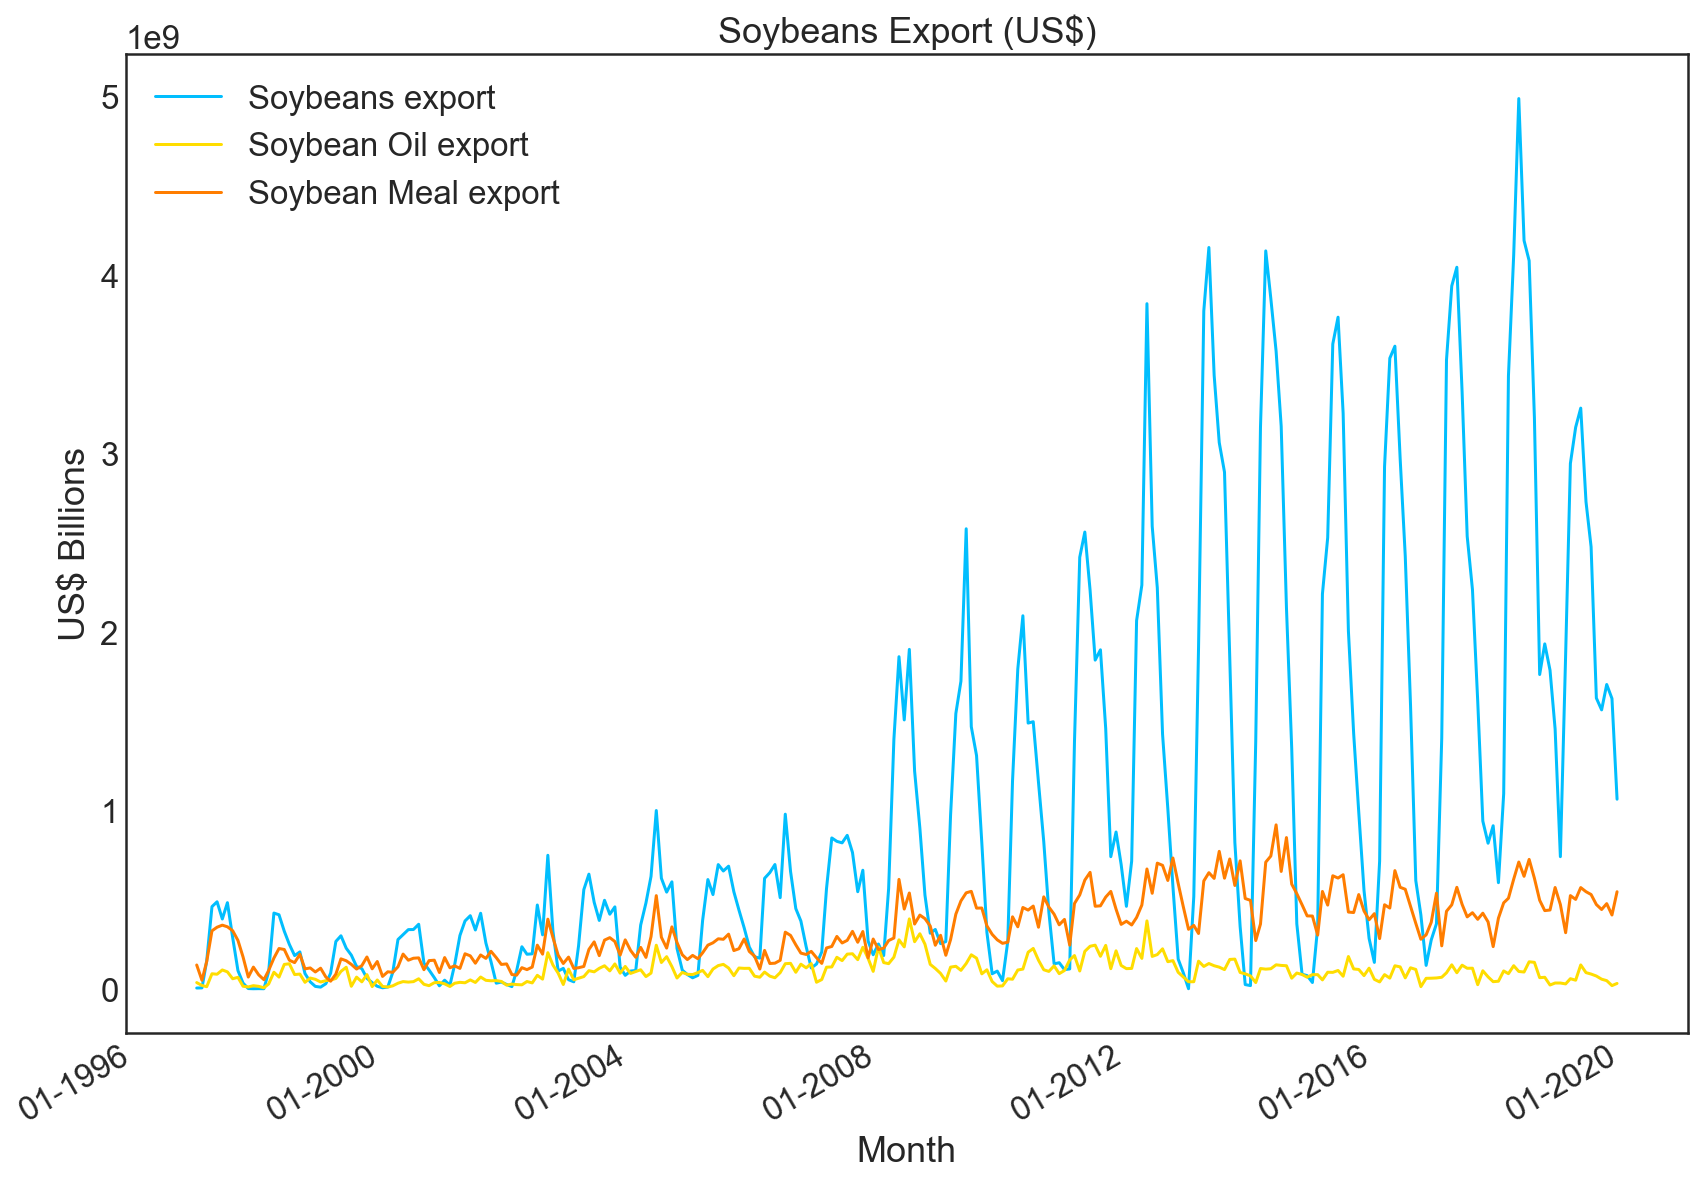

In [48]:
years_fmt = DateFormatter('%Y')
months_fmt = DateFormatter('%m-%Y')
days_fmt = DateFormatter('%d')
fig, ax = plt.subplots()
ax.plot(soybeans_export_month, label='Soybeans export')
ax.plot(soybean_oil_export_month, label='Soybean Oil export')
ax.plot(soybean_meal_export_month, label='Soybean Meal export')
# format the ticks
ax.xaxis.set_major_formatter(months_fmt)
fig.autofmt_xdate()
plt.xlabel('Month')
plt.ylabel('US$ Billions')
plt.title("Soybeans Export (US$)")
plt.legend();

## Evolution of annual exports from Brazil of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

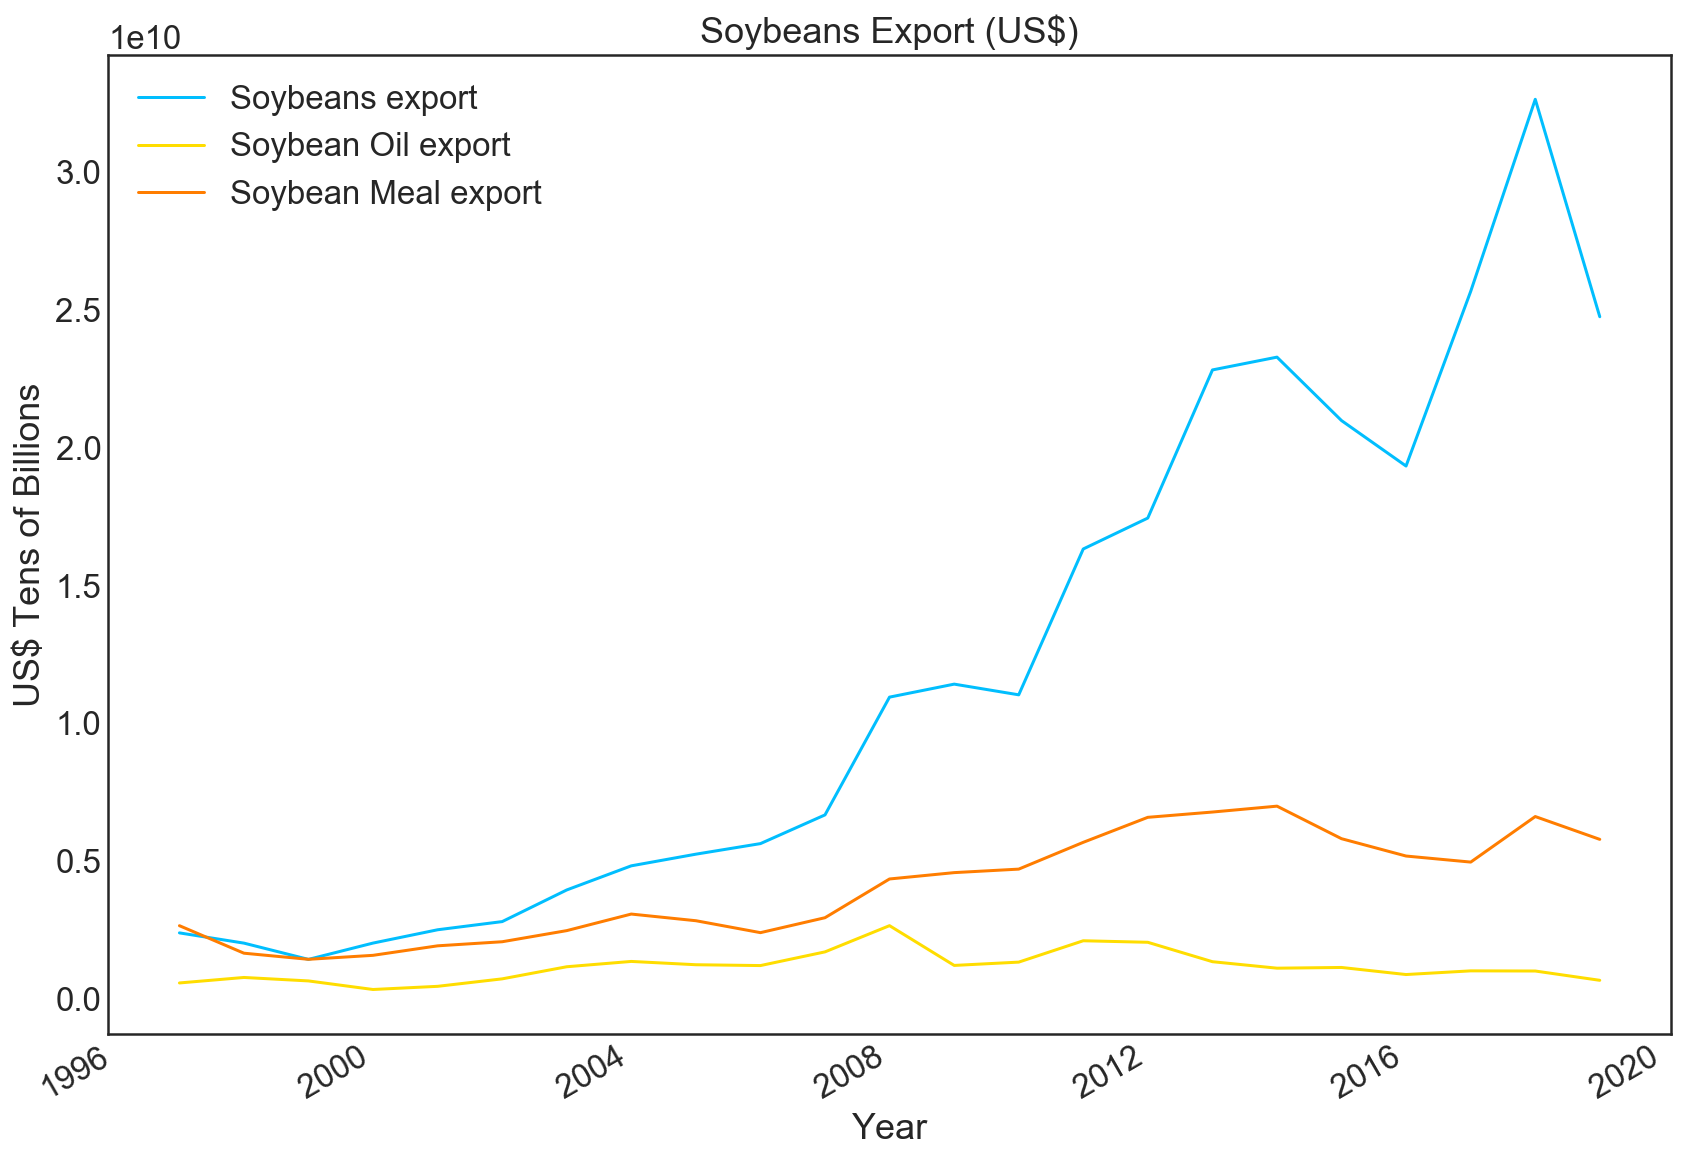

In [49]:
years_fmt = DateFormatter('%Y')
months_fmt = DateFormatter('%m')
days_fmt = DateFormatter('%d')
fig, ax = plt.subplots()
ax.plot(soybeans_export_year, label='Soybeans export')
ax.plot(soybean_oil_export_year, label='Soybean Oil export')
ax.plot(soybean_meal_export_year, label='Soybean Meal export')
# format the ticks
#ax.xaxis.set_major_formatter(years_fmt)
fig.autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('US$ Tens of Billions')
plt.title("Soybeans Export (US$)")
plt.legend();

## Evolution of annual exports from Brazil during the last 5 years

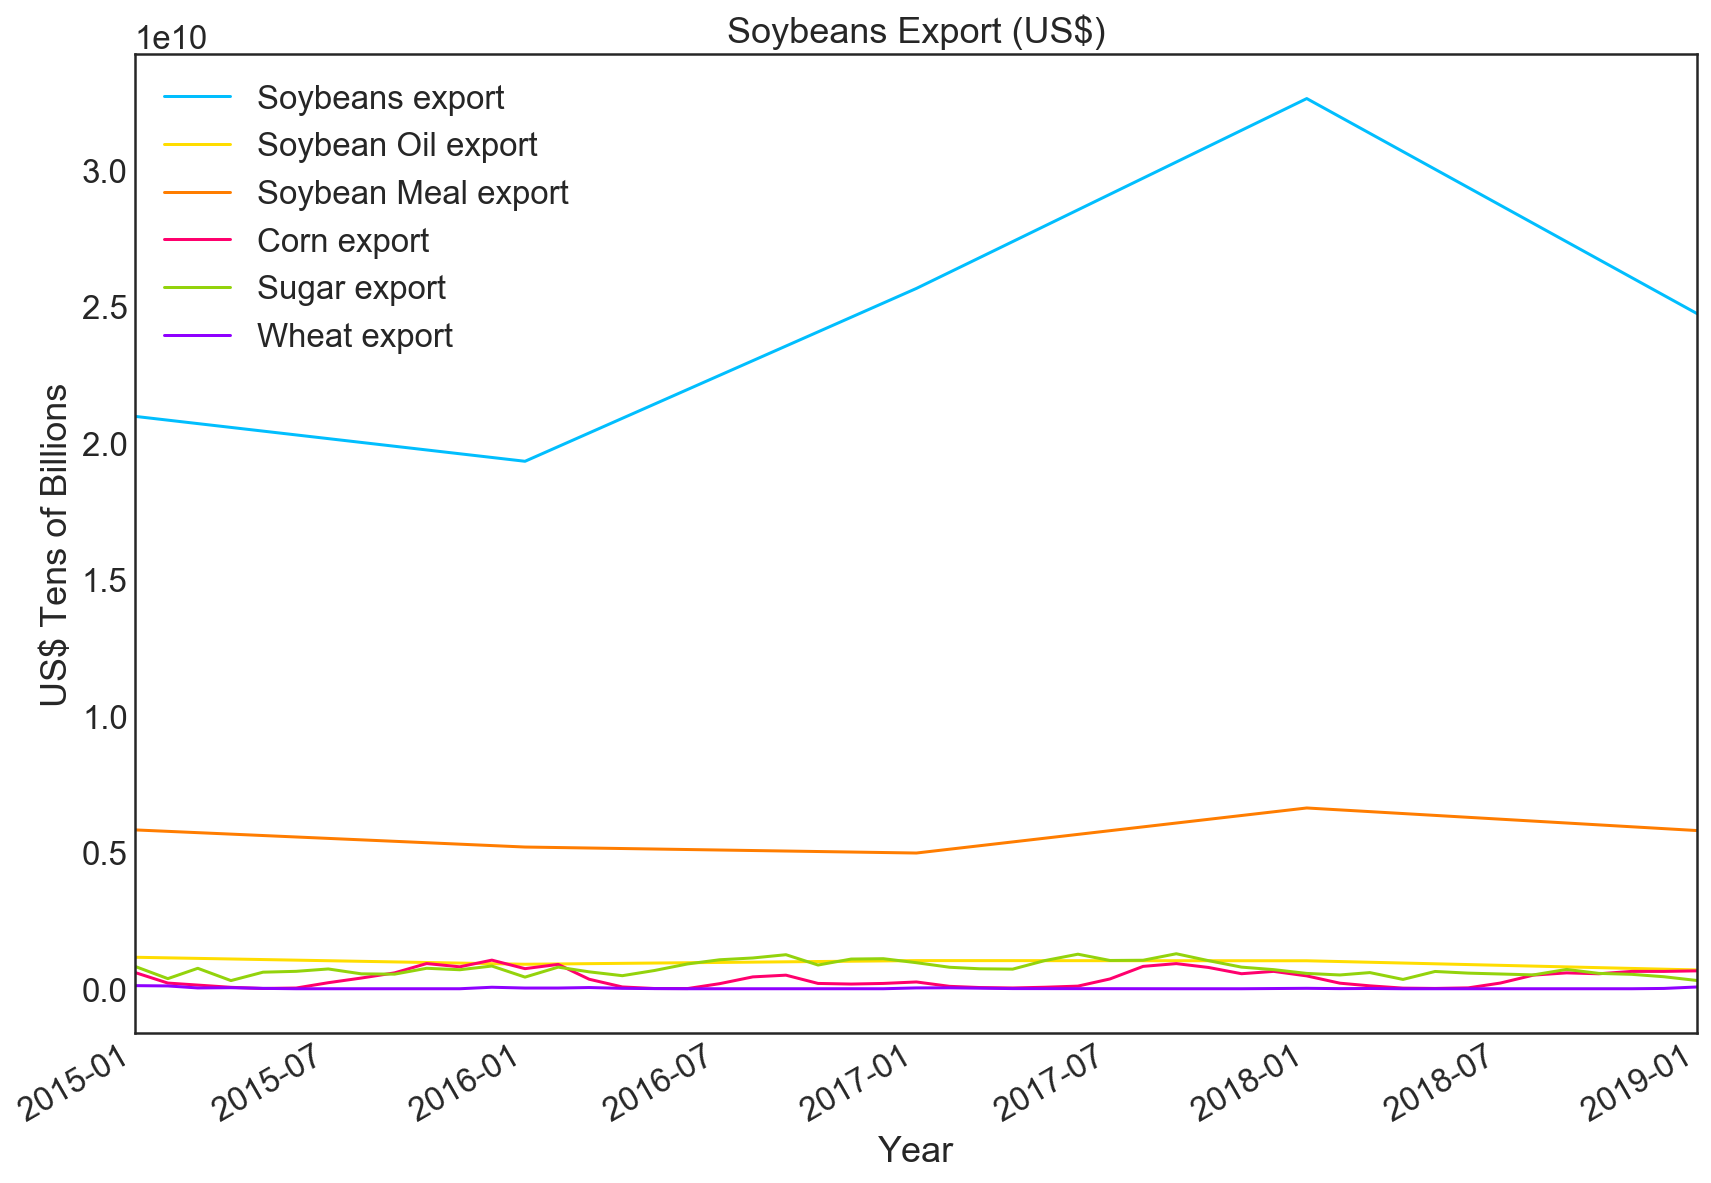

In [50]:
years_fmt = DateFormatter('%Y')
months_fmt = DateFormatter('%m')
days_fmt = DateFormatter('%d')
fig, ax = plt.subplots()
ax.plot(soybeans_export_year, label='Soybeans export')
ax.plot(soybean_oil_export_year, label='Soybean Oil export')
ax.plot(soybean_meal_export_year, label='Soybean Meal export')
ax.plot(corn_export_month, label='Corn export')
ax.plot(sugar_export_month, label='Sugar export')
ax.plot(wheat_export_month, label='Wheat export')
ax.set(xlim=["2015-01-01", "2019-01-01"])
# format the ticks
#ax.xaxis.set_major_formatter(years_fmt)
fig.autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('US$ Tens of Billions')
plt.title("Soybeans Export (US$)")
plt.legend();

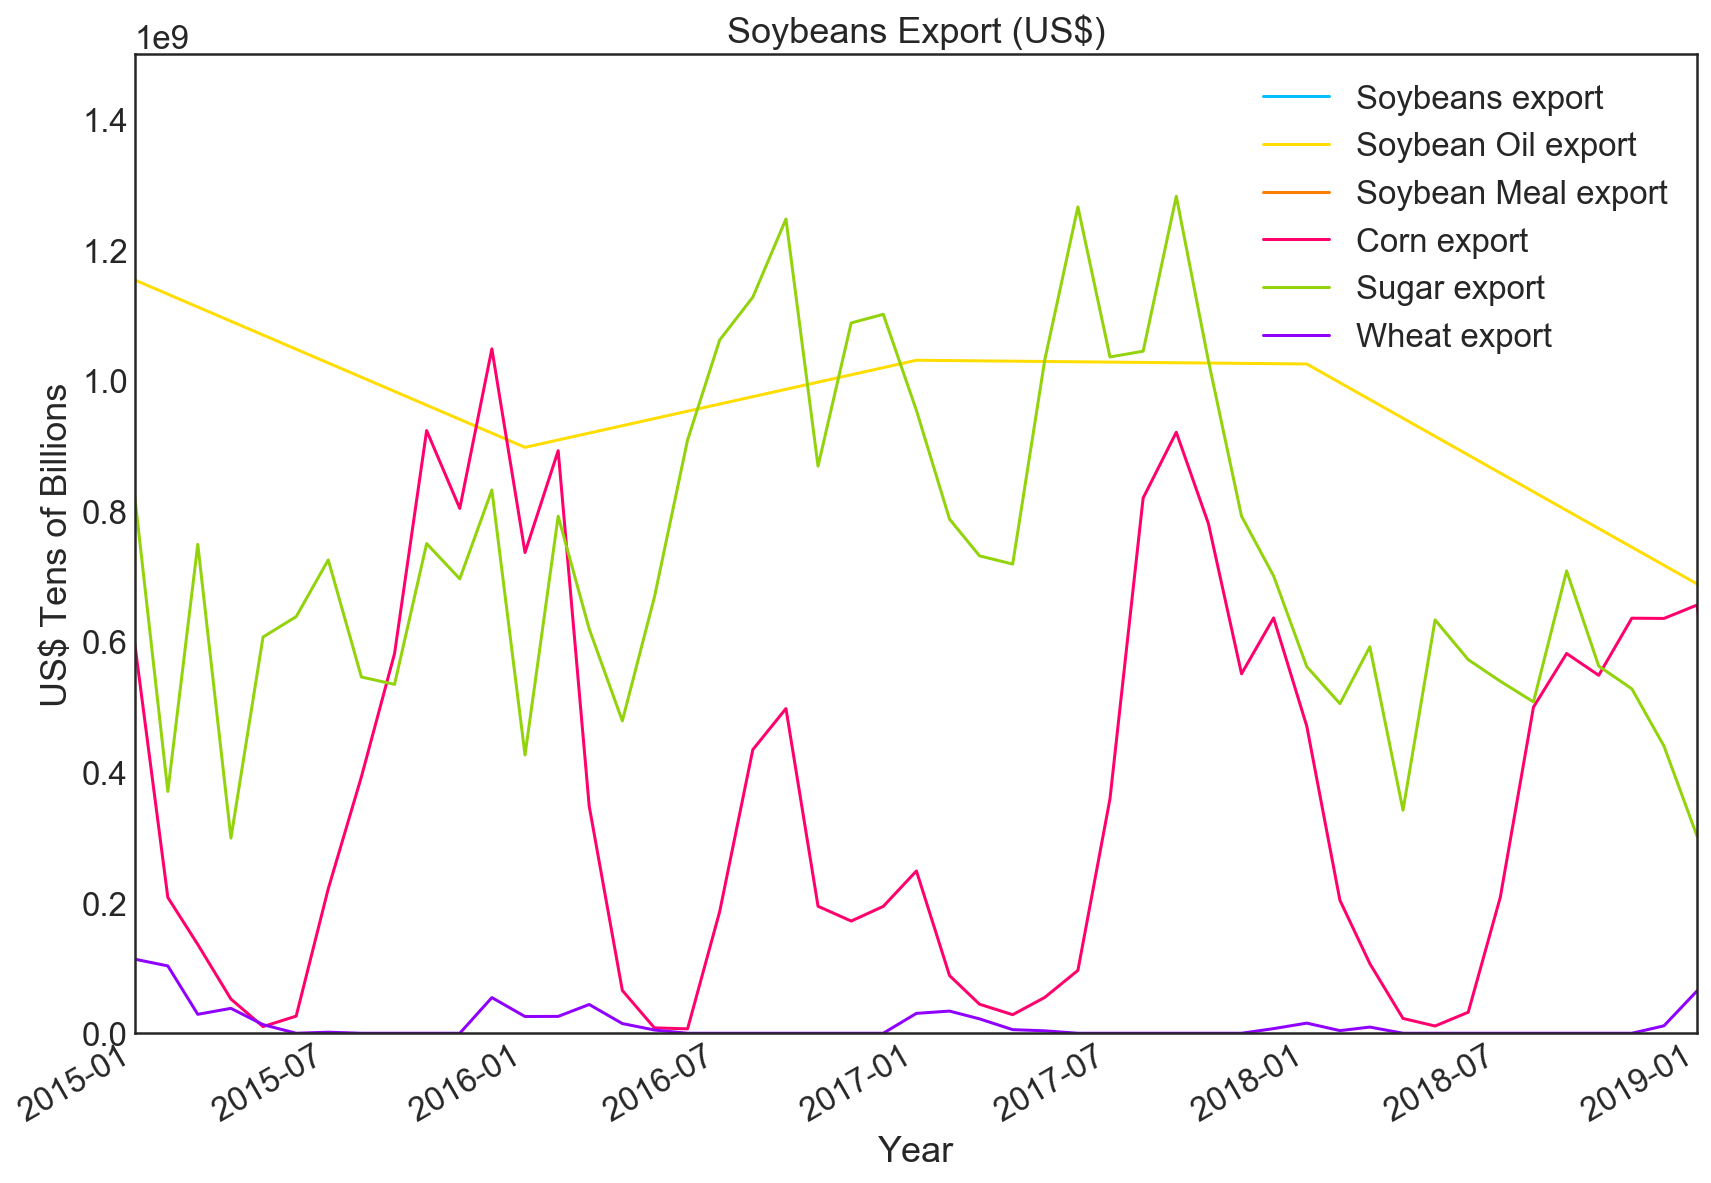

In [51]:
years_fmt = DateFormatter('%Y')
months_fmt = DateFormatter('%m')
days_fmt = DateFormatter('%d')
fig, ax = plt.subplots()
ax.plot(soybeans_export_year, label='Soybeans export')
ax.plot(soybean_oil_export_year, label='Soybean Oil export')
ax.plot(soybean_meal_export_year, label='Soybean Meal export')
ax.plot(corn_export_month, label='Corn export')
ax.plot(sugar_export_month, label='Sugar export')
ax.plot(wheat_export_month, label='Wheat export')
ax.set(xlim=["2015-01-01", "2019-01-01"])
plt.ylim((0, 1500000000))
# format the ticks
#ax.xaxis.set_major_formatter(years_fmt)
fig.autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('US$ Tens of Billions')
plt.title("Soybeans Export (US$)")
plt.legend();

## Soybeans, Soybean Meal and Soybean Oil are the 3 most important products exported by Brazil in the last 5 years

In [52]:
df_corn = corn_export[['date','route','usd']]
df_corn

,date,route,usd
2,1997-01-01,Ground,180.0
3,1997-01-01,Sea,5688.0
5,1997-01-01,Ground,38700.0
9,1997-01-01,Sea,20000000.0
10,1997-01-01,Ground,386733.0
...,...,...,...
117265,2019-12-01,Sea,402284.0
117266,2019-12-01,Sea,4433950.0
117267,2019-12-01,Sea,229003.0
117268,2019-12-01,Air,27.0


In [53]:
df_corn = df_corn.pivot_table(index='date',columns='route',aggfunc=sum)
df_corn

usd                                           
route           Air      Ground      Other River           Sea
date                                                          
1997-01-01   6999.0    468341.0     1876.0   NaN  2.014809e+07
1997-02-01   9450.0     47140.0        NaN   NaN  1.308137e+07
1997-03-01   3097.0      1025.0        NaN   NaN  6.676094e+06
1997-04-01   1814.0    595830.0      468.0   NaN  3.461483e+06
1997-05-01  19487.0   1529484.0      553.0   NaN           NaN
...             ...         ...        ...   ...           ...
2019-08-01  24533.0    347019.0  7800115.0   NaN  1.198407e+09
2019-09-01   4337.0   1681493.0  8634817.0   NaN  1.040951e+09
2019-10-01  63991.0   7134728.0  9695387.0   NaN  9.683883e+08
2019-11-01  10766.0   5115074.0     3453.0   NaN  6.848031e+08
2019-12-01    633.0  15047599.0    45001.0   NaN  6.852762e+08

[276 rows x 5 columns]

In [54]:
df_corn.fillna(0,inplace=True)
df_corn.columns = df_corn.columns.droplevel()
df_corn.columns.name = None
df_corn.reset_index(inplace=True)
df_corn

,date,Air,Ground,Other,River,Sea
0,1997-01-01,6999.0,468341.0,1876.0,0.0,2.014809e+07
1,1997-02-01,9450.0,47140.0,0.0,0.0,1.308137e+07
2,1997-03-01,3097.0,1025.0,0.0,0.0,6.676094e+06
3,1997-04-01,1814.0,595830.0,468.0,0.0,3.461483e+06
4,1997-05-01,19487.0,1529484.0,553.0,0.0,0.000000e+00
...,...,...,...,...,...,...
271,2019-08-01,24533.0,347019.0,7800115.0,0.0,1.198407e+09
272,2019-09-01,4337.0,1681493.0,8634817.0,0.0,1.040951e+09
273,2019-10-01,63991.0,7134728.0,9695387.0,0.0,9.683883e+08
274,2019-11-01,10766.0,5115074.0,3453.0,0.0,6.848031e+08


In [55]:
df_corn.sum(axis = 0, skipna = True)

Air       1.489480e+07
Ground    4.963856e+08
Other     4.585836e+07
River     1.666881e+09
Sea       4.974177e+10
dtype: float64

In [56]:
df_corn_5_years = df_corn[216:]
df_corn_5_years

,date,Air,Ground,Other,River,Sea
216,2015-01-01,15629.0,3208232.0,56806.0,22229330.0,5.724506e+08
217,2015-02-01,20.0,712628.0,17999.0,12027107.0,1.952371e+08
218,2015-03-01,7850.0,532711.0,21678.0,5453070.0,1.299785e+08
219,2015-04-01,6042.0,73873.0,26904.0,0.0,5.223776e+07
220,2015-05-01,55923.0,140724.0,25601.0,0.0,9.974425e+06
221,2015-06-01,926.0,135187.0,28401.0,0.0,2.607786e+07
222,2015-07-01,1593237.0,344511.0,22379.0,31498567.0,1.878602e+08
223,2015-08-01,64070.0,337621.0,3510.0,37046503.0,3.554167e+08
224,2015-09-01,28172.0,98543.0,12306.0,53453003.0,5.280791e+08
225,2015-10-01,44919.0,24222.0,4366.0,26764521.0,8.963901e+08


In [57]:
df_corn_5_years.sum(axis = 0, skipna = True)

Air       4.334926e+06
Ground    1.717586e+08
Other     4.413550e+07
River     9.663762e+08
Sea       2.326112e+10
dtype: float64

## During the last 5 years Brazil has been exporting corn mainly by Sea, followed by River and by Ground, based on the amount of US Dollars.

In [58]:
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [59]:
soybeans = df[Filter_soybeans]
soybeans

,date,product,state,country,type,route,tons,usd
73,1997-01-01,soybeans,GO,Spain,Export,Sea,13730.000,3954240.0
74,1997-01-01,soybeans,MT,Bolivia,Export,Other,100.000,60500.0
75,1997-01-01,soybeans,RS,Argentina,Export,Ground,200.000,104000.0
167,1997-02-01,soybeans,GO,Netherlands,Export,Sea,3000.000,855450.0
168,1997-02-01,soybeans,MT,Netherlands,Export,Sea,5000.000,1436185.0
...,...,...,...,...,...,...,...,...
117584,2019-12-01,soybeans,SP,Liberia,Export,Other,0.004,11.0
117585,2019-12-01,soybeans,SP,Liberia,Export,Other,0.006,30.0
117586,2019-12-01,soybeans,SP,Thailand,Export,Sea,146.499,52813.0
117587,2019-12-01,soybeans,TO,China,Export,Sea,63731.482,22986541.0


In [60]:
soybean_oil = df[Filter_soybean_oil]
soybean_oil

,date,product,state,country,type,route,tons,usd
57,1997-01-01,soybean_oil,MS,Bolivia,Export,Other,48.053,43268.0
58,1997-01-01,soybean_oil,MT,China,Export,Sea,6000.000,3002191.0
59,1997-01-01,soybean_oil,PE,Argentina,Import,Sea,7140.000,3666390.0
60,1997-01-01,soybean_oil,PR,Argentina,Import,Sea,3000.000,1560000.0
61,1997-01-01,soybean_oil,PR,Bangladesh,Export,Sea,5430.000,2920399.0
...,...,...,...,...,...,...,...,...
117499,2019-12-01,soybean_oil,SP,Paraguay,Export,Ground,4.004,12212.0
117500,2019-12-01,soybean_oil,SP,Singapore,Export,Other,0.154,278.0
117501,2019-12-01,soybean_oil,SP,South Korea,Export,Other,0.020,14.0
117502,2019-12-01,soybean_oil,SP,United Kingdom,Export,Other,0.180,208.0


In [61]:
soybean_meal = df[Filter_soybean_meal]
soybean_meal

,date,product,state,country,type,route,tons,usd
19,1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,419.070,119318.0
20,1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,5000.000,1414250.0
21,1997-01-01,soybean_meal,MS,Germany,Export,Sea,140.672,38378.0
22,1997-01-01,soybean_meal,MS,Hungary,Export,Sea,15000.000,4042100.0
23,1997-01-01,soybean_meal,MS,Netherlands,Export,Sea,14000.000,3850162.0
...,...,...,...,...,...,...,...,...
117367,2019-12-01,soybean_meal,SP,United Kingdom,Export,Sea,2259.887,800000.0
117368,2019-12-01,soybean_meal,SP,Vietnam,Export,Sea,17300.000,5803448.0
117369,2019-12-01,soybean_meal,TO,France,Export,Sea,1537.455,466218.0
117370,2019-12-01,soybean_meal,TO,South Korea,Export,Sea,2933.194,889462.0


In [62]:
corn = df[Filter_corn]
corn

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117265,2019-12-01,corn,SP,Vietnam,Export,Sea,2575.793,402284.0
117266,2019-12-01,corn,TO,Egypt,Export,Sea,27908.815,4433950.0
117267,2019-12-01,corn,TO,Kuwait,Export,Sea,1293.930,229003.0
117268,2019-12-01,corn,TO,Philippines,Export,Air,0.007,27.0


In [63]:
sugar = df[Filter_sugar]
sugar

,date,product,state,country,type,route,tons,usd
76,1997-01-01,sugar,PE,Algeria,Export,Air,1000.000,307000.0
77,1997-01-01,sugar,PE,Algeria,Export,Sea,12400.000,3587650.0
78,1997-01-01,sugar,PE,Gambia,Export,Sea,3560.000,1032400.0
79,1997-01-01,sugar,PE,Ghana,Export,Sea,9040.000,2798359.0
80,1997-01-01,sugar,PE,Iran,Export,Sea,28000.000,8190000.0
...,...,...,...,...,...,...,...,...
117919,2019-12-01,sugar,SP,Uruguay,Export,Ground,1890.000,577618.0
117920,2019-12-01,sugar,SP,Venezuela,Export,Ground,80.000,55491.0
117921,2019-12-01,sugar,SP,Venezuela,Export,Sea,8967.646,3828624.0
117922,2019-12-01,sugar,SP,Yemen,Export,Sea,5805.000,1726058.0


In [64]:
wheat = df[Filter_wheat]
wheat

,date,product,state,country,type,route,tons,usd
17466,2003-12-01,wheat,MG,United States,Export,Sea,1.500,657.0
17711,2004-01-01,wheat,MG,United States,Export,Sea,3.000,1269.0
20180,2004-09-01,wheat,SP,Lebanon,Import,Sea,0.010,5.0
21208,2005-01-01,wheat,MG,United States,Export,Sea,0.400,164.0
21780,2005-03-01,wheat,MG,United States,Export,Sea,0.400,170.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [65]:
soybeans = soybeans[['date','route','usd']]
soybeans

,date,route,usd
73,1997-01-01,Sea,3954240.0
74,1997-01-01,Other,60500.0
75,1997-01-01,Ground,104000.0
167,1997-02-01,Sea,855450.0
168,1997-02-01,Sea,1436185.0
...,...,...,...
117584,2019-12-01,Other,11.0
117585,2019-12-01,Other,30.0
117586,2019-12-01,Sea,52813.0
117587,2019-12-01,Sea,22986541.0


In [66]:
soybean_oil = soybean_oil[['date','route','usd']]
soybean_oil

,date,route,usd
57,1997-01-01,Other,43268.0
58,1997-01-01,Sea,3002191.0
59,1997-01-01,Sea,3666390.0
60,1997-01-01,Sea,1560000.0
61,1997-01-01,Sea,2920399.0
...,...,...,...
117499,2019-12-01,Ground,12212.0
117500,2019-12-01,Other,278.0
117501,2019-12-01,Other,14.0
117502,2019-12-01,Other,208.0


In [67]:
soybean_meal = soybean_meal[['date','route','usd']]
soybean_meal

,date,route,usd
19,1997-01-01,Sea,119318.0
20,1997-01-01,Sea,1414250.0
21,1997-01-01,Sea,38378.0
22,1997-01-01,Sea,4042100.0
23,1997-01-01,Sea,3850162.0
...,...,...,...
117367,2019-12-01,Sea,800000.0
117368,2019-12-01,Sea,5803448.0
117369,2019-12-01,Sea,466218.0
117370,2019-12-01,Sea,889462.0


In [68]:
corn = corn[['date','route','usd']]
corn

,date,route,usd
0,1997-01-01,Sea,113029.0
1,1997-01-01,Ground,36720.0
2,1997-01-01,Ground,180.0
3,1997-01-01,Sea,5688.0
4,1997-01-01,Ground,18630.0
...,...,...,...
117265,2019-12-01,Sea,402284.0
117266,2019-12-01,Sea,4433950.0
117267,2019-12-01,Sea,229003.0
117268,2019-12-01,Air,27.0


In [69]:
sugar = sugar[['date','route','usd']]
sugar

,date,route,usd
76,1997-01-01,Air,307000.0
77,1997-01-01,Sea,3587650.0
78,1997-01-01,Sea,1032400.0
79,1997-01-01,Sea,2798359.0
80,1997-01-01,Sea,8190000.0
...,...,...,...
117919,2019-12-01,Ground,577618.0
117920,2019-12-01,Ground,55491.0
117921,2019-12-01,Sea,3828624.0
117922,2019-12-01,Sea,1726058.0


In [70]:
wheat = wheat[['date','route','usd']]
wheat

,date,route,usd
17466,2003-12-01,Sea,657.0
17711,2004-01-01,Sea,1269.0
20180,2004-09-01,Sea,5.0
21208,2005-01-01,Sea,164.0
21780,2005-03-01,Sea,170.0
...,...,...,...
117960,2019-12-01,Sea,17897516.0
117961,2019-12-01,Sea,477.0
117962,2019-12-01,Sea,6726.0
117963,2019-12-01,Other,50.0


In [71]:
soybeans = soybeans.pivot_table(index='date',columns='route',aggfunc=sum)
soybeans

usd                                                  
route          Air      Ground       Other       River           Sea
date                                                                
1997-01-01     NaN    104000.0     60500.0         NaN  3.954240e+06
1997-02-01     NaN         NaN         NaN         NaN  2.050609e+07
1997-03-01     NaN   7361815.0         NaN         NaN  1.562010e+08
1997-04-01     NaN  41428539.0         NaN   1902494.0  4.575187e+08
1997-05-01     NaN  13035741.0         NaN   7188151.0  4.800764e+08
...            ...         ...         ...         ...           ...
2019-08-01  4084.0   6236871.0  13817597.0  10989190.0  1.601741e+09
2019-09-01   242.0   2272011.0  36526682.0         NaN  1.525708e+09
2019-10-01   384.0    721233.0  28898621.0         NaN  1.675376e+09
2019-11-01  1799.0   2055086.0        11.0         NaN  1.625833e+09
2019-12-01   814.0   4594617.0       195.0         NaN  1.061574e+09

[276 rows x 5 columns]

In [72]:
soybean_oil = soybean_oil.pivot_table(index='date',columns='route',aggfunc=sum)
soybean_oil

usd                                           
route           Air     Ground      Other    River         Sea
date                                                          
1997-01-01      NaN  1435931.0   259722.0      NaN  39615745.0
1997-02-01      NaN  5949354.0    65759.0      NaN  18116564.0
1997-03-01      NaN  3655710.0    19322.0      NaN  11501529.0
1997-04-01     12.0  1537850.0   250137.0      NaN  84726806.0
1997-05-01  27797.0  3845500.0   104047.0      NaN  81280157.0
...             ...        ...        ...      ...         ...
2019-08-01    728.0  4236352.0    24418.0      NaN  67938885.0
2019-09-01   1894.0  6985829.0  1278906.0      NaN  45920812.0
2019-10-01   1832.0  6169375.0    70582.0  88906.0  46535560.0
2019-11-01    126.0  5936363.0    30935.0  90115.0  12085613.0
2019-12-01      NaN  6548492.0    38877.0      NaN  35642304.0

[276 rows x 5 columns]

In [73]:
soybean_meal = soybean_meal.pivot_table(index='date',columns='route',aggfunc=sum)
soybean_meal

usd                                        
route          Air     Ground     Other River          Sea
date                                                      
1997-01-01     NaN  1176945.0       NaN   NaN  134235357.0
1997-02-01   848.0  6264920.0       NaN   NaN   47987191.0
1997-03-01     NaN  1487637.0       NaN   NaN  152682096.0
1997-04-01     NaN  1859520.0       NaN   NaN  324619851.0
1997-05-01     NaN  3710108.0       NaN   NaN  344844289.0
...            ...        ...       ...   ...          ...
2019-08-01     5.0    50128.0   15452.0   NaN  471815582.0
2019-09-01     4.0   583000.0  107754.0   NaN  444078335.0
2019-10-01  3100.0    52078.0       NaN   NaN  476823087.0
2019-11-01     NaN        NaN       NaN   NaN  413260305.0
2019-12-01     NaN    19500.0       NaN   NaN  543775559.0

[276 rows x 5 columns]

In [74]:
corn = corn.pivot_table(index='date',columns='route',aggfunc=sum)
corn

usd                                           
route            Air      Ground      Other River           Sea
date                                                           
1997-01-01    6999.0    823161.0     1876.0   NaN  2.151666e+07
1997-02-01    9450.0   3317789.0        NaN   NaN  1.514595e+07
1997-03-01   14451.0   2377258.0        NaN   NaN  1.034959e+07
1997-04-01    1814.0   2179667.0      468.0   NaN  1.046348e+07
1997-05-01   19487.0   4148249.0      553.0   NaN  2.271023e+06
...              ...         ...        ...   ...           ...
2019-08-01   28453.0  15486804.0  7800115.0   NaN  1.198632e+09
2019-09-01   12254.0  20528792.0  8634817.0   NaN  1.041146e+09
2019-10-01  107617.0  34252091.0  9695387.0   NaN  9.693834e+08
2019-11-01   53924.0  32497363.0     3453.0   NaN  6.848031e+08
2019-12-01    1037.0  39365039.0    45001.0   NaN  6.863982e+08

[276 rows x 5 columns]

In [75]:
sugar = sugar.pivot_table(index='date',columns='route',aggfunc=sum)
sugar

usd                                               
route            Air      Ground      Other      River          Sea
date                                                               
1997-01-01  491200.0     34825.0     2175.0        NaN   39915974.0
1997-02-01      30.0     17464.0     1530.0        NaN    8176535.0
1997-03-01    2071.0      7825.0      977.0        NaN   18940610.0
1997-04-01      67.0    307485.0      141.0        NaN   29662925.0
1997-05-01     438.0   1178497.0      619.0        NaN   21424625.0
...              ...         ...        ...        ...          ...
2019-08-01    4970.0   3089283.0    10610.0   542766.0  458863100.0
2019-09-01   11092.0   5373246.0  3536950.0        NaN  476874972.0
2019-10-01    3939.0   6798073.0    14360.0        NaN  530617749.0
2019-11-01   12280.0  14082480.0  1564487.0  1240000.0  542308496.0
2019-12-01    4030.0  15574930.0   181558.0        NaN  378017303.0

[276 rows x 5 columns]

In [76]:
wheat = wheat.pivot_table(index='date',columns='route',aggfunc=sum)
wheat

usd                                          
route          Air      Ground  Other     River          Sea
date                                                        
2003-12-01     NaN         NaN    NaN       NaN        657.0
2004-01-01     NaN         NaN    NaN       NaN       1269.0
2004-09-01     NaN         NaN    NaN       NaN          5.0
2005-01-01     NaN         NaN    NaN       NaN        164.0
2005-03-01     NaN         NaN    NaN       NaN        170.0
...            ...         ...    ...       ...          ...
2019-08-01     3.0   9810353.0  109.0  241313.0  101739807.0
2019-09-01  1018.0   8474084.0  287.0  500785.0  105680646.0
2019-10-01     0.0  11240151.0   85.0       NaN  127410644.0
2019-11-01  9004.0   4598300.0    NaN  243814.0   90668821.0
2019-12-01     1.0   3620223.0  135.0       NaN  129449924.0

[163 rows x 5 columns]

In [77]:
soybeans.fillna(0,inplace=True)
soybeans.columns = soybeans.columns.droplevel()
soybeans.columns.name = None
soybeans.reset_index(inplace=True)
soybeans

,date,Air,Ground,Other,River,Sea
0,1997-01-01,0.0,104000.0,60500.0,0.0,3.954240e+06
1,1997-02-01,0.0,0.0,0.0,0.0,2.050609e+07
2,1997-03-01,0.0,7361815.0,0.0,0.0,1.562010e+08
3,1997-04-01,0.0,41428539.0,0.0,1902494.0,4.575187e+08
4,1997-05-01,0.0,13035741.0,0.0,7188151.0,4.800764e+08
...,...,...,...,...,...,...
271,2019-08-01,4084.0,6236871.0,13817597.0,10989190.0,1.601741e+09
272,2019-09-01,242.0,2272011.0,36526682.0,0.0,1.525708e+09
273,2019-10-01,384.0,721233.0,28898621.0,0.0,1.675376e+09
274,2019-11-01,1799.0,2055086.0,11.0,0.0,1.625833e+09


In [78]:
soybean_oil.fillna(0,inplace=True)
soybean_oil.columns = soybean_oil.columns.droplevel()
soybean_oil.columns.name = None
soybean_oil.reset_index(inplace=True)
soybean_oil

,date,Air,Ground,Other,River,Sea
0,1997-01-01,0.0,1435931.0,259722.0,0.0,39615745.0
1,1997-02-01,0.0,5949354.0,65759.0,0.0,18116564.0
2,1997-03-01,0.0,3655710.0,19322.0,0.0,11501529.0
3,1997-04-01,12.0,1537850.0,250137.0,0.0,84726806.0
4,1997-05-01,27797.0,3845500.0,104047.0,0.0,81280157.0
...,...,...,...,...,...,...
271,2019-08-01,728.0,4236352.0,24418.0,0.0,67938885.0
272,2019-09-01,1894.0,6985829.0,1278906.0,0.0,45920812.0
273,2019-10-01,1832.0,6169375.0,70582.0,88906.0,46535560.0
274,2019-11-01,126.0,5936363.0,30935.0,90115.0,12085613.0


In [79]:
soybean_meal.fillna(0,inplace=True)
soybean_meal.columns = soybean_meal.columns.droplevel()
soybean_meal.columns.name = None
soybean_meal.reset_index(inplace=True)
soybean_meal

,date,Air,Ground,Other,River,Sea
0,1997-01-01,0.0,1176945.0,0.0,0.0,134235357.0
1,1997-02-01,848.0,6264920.0,0.0,0.0,47987191.0
2,1997-03-01,0.0,1487637.0,0.0,0.0,152682096.0
3,1997-04-01,0.0,1859520.0,0.0,0.0,324619851.0
4,1997-05-01,0.0,3710108.0,0.0,0.0,344844289.0
...,...,...,...,...,...,...
271,2019-08-01,5.0,50128.0,15452.0,0.0,471815582.0
272,2019-09-01,4.0,583000.0,107754.0,0.0,444078335.0
273,2019-10-01,3100.0,52078.0,0.0,0.0,476823087.0
274,2019-11-01,0.0,0.0,0.0,0.0,413260305.0


In [80]:
corn.fillna(0,inplace=True)
corn.columns = corn.columns.droplevel()
corn.columns.name = None
corn.reset_index(inplace=True)
corn

,date,Air,Ground,Other,River,Sea
0,1997-01-01,6999.0,823161.0,1876.0,0.0,2.151666e+07
1,1997-02-01,9450.0,3317789.0,0.0,0.0,1.514595e+07
2,1997-03-01,14451.0,2377258.0,0.0,0.0,1.034959e+07
3,1997-04-01,1814.0,2179667.0,468.0,0.0,1.046348e+07
4,1997-05-01,19487.0,4148249.0,553.0,0.0,2.271023e+06
...,...,...,...,...,...,...
271,2019-08-01,28453.0,15486804.0,7800115.0,0.0,1.198632e+09
272,2019-09-01,12254.0,20528792.0,8634817.0,0.0,1.041146e+09
273,2019-10-01,107617.0,34252091.0,9695387.0,0.0,9.693834e+08
274,2019-11-01,53924.0,32497363.0,3453.0,0.0,6.848031e+08


In [81]:
sugar.fillna(0,inplace=True)
sugar.columns = sugar.columns.droplevel()
sugar.columns.name = None
sugar.reset_index(inplace=True)
sugar

,date,Air,Ground,Other,River,Sea
0,1997-01-01,491200.0,34825.0,2175.0,0.0,39915974.0
1,1997-02-01,30.0,17464.0,1530.0,0.0,8176535.0
2,1997-03-01,2071.0,7825.0,977.0,0.0,18940610.0
3,1997-04-01,67.0,307485.0,141.0,0.0,29662925.0
4,1997-05-01,438.0,1178497.0,619.0,0.0,21424625.0
...,...,...,...,...,...,...
271,2019-08-01,4970.0,3089283.0,10610.0,542766.0,458863100.0
272,2019-09-01,11092.0,5373246.0,3536950.0,0.0,476874972.0
273,2019-10-01,3939.0,6798073.0,14360.0,0.0,530617749.0
274,2019-11-01,12280.0,14082480.0,1564487.0,1240000.0,542308496.0


In [82]:
wheat.fillna(0,inplace=True)
wheat.columns = wheat.columns.droplevel()
wheat.columns.name = None
wheat.reset_index(inplace=True)
wheat

,date,Air,Ground,Other,River,Sea
0,2003-12-01,0.0,0.0,0.0,0.0,657.0
1,2004-01-01,0.0,0.0,0.0,0.0,1269.0
2,2004-09-01,0.0,0.0,0.0,0.0,5.0
3,2005-01-01,0.0,0.0,0.0,0.0,164.0
4,2005-03-01,0.0,0.0,0.0,0.0,170.0
...,...,...,...,...,...,...
158,2019-08-01,3.0,9810353.0,109.0,241313.0,101739807.0
159,2019-09-01,1018.0,8474084.0,287.0,500785.0,105680646.0
160,2019-10-01,0.0,11240151.0,85.0,0.0,127410644.0
161,2019-11-01,9004.0,4598300.0,0.0,243814.0,90668821.0


In [83]:
soybeans.sum(axis = 0, skipna = True)

Air       3.131050e+05
Ground    2.345389e+09
Other     5.722220e+08
River     7.214311e+09
Sea       2.686037e+11
dtype: float64

In [84]:
soybean_oil.sum(axis = 0, skipna = True)

Air       1.365993e+06
Ground    4.868319e+08
Other     1.022077e+08
River     2.599700e+07
Sea       2.717758e+10
dtype: float64

In [85]:
soybean_meal.sum(axis = 0, skipna = True)

Air       8.442259e+06
Ground    4.615589e+08
Other     3.054465e+07
River     7.182727e+07
Sea       9.326658e+10
dtype: float64

In [86]:
corn.sum(axis = 0, skipna = True)

Air       2.201639e+07
Ground    2.573138e+09
Other     4.665101e+07
River     1.666881e+09
Sea       5.061211e+10
dtype: float64

In [87]:
sugar.sum(axis = 0, skipna = True)

Air       2.471541e+06
Ground    5.077324e+08
Other     5.970901e+07
River     1.039980e+08
Sea       9.740790e+10
dtype: float64

In [88]:
wheat.sum(axis = 0, skipna = True)

Air       1.756400e+04
Ground    8.841966e+08
Other     2.305500e+04
River     8.984863e+06
Sea       1.351858e+10
dtype: float64

## Independent of the product and including import and export the Sea route is far the most important one. The second most important route for soybeans is River. For all other products Ground is the second most important route (the US Dollars amount was used to rank the routes).

In [89]:
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [90]:
corn = df[Filter_corn]
corn

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117265,2019-12-01,corn,SP,Vietnam,Export,Sea,2575.793,402284.0
117266,2019-12-01,corn,TO,Egypt,Export,Sea,27908.815,4433950.0
117267,2019-12-01,corn,TO,Kuwait,Export,Sea,1293.930,229003.0
117268,2019-12-01,corn,TO,Philippines,Export,Air,0.007,27.0


In [91]:
sugar = df[Filter_sugar]
sugar

,date,product,state,country,type,route,tons,usd
76,1997-01-01,sugar,PE,Algeria,Export,Air,1000.000,307000.0
77,1997-01-01,sugar,PE,Algeria,Export,Sea,12400.000,3587650.0
78,1997-01-01,sugar,PE,Gambia,Export,Sea,3560.000,1032400.0
79,1997-01-01,sugar,PE,Ghana,Export,Sea,9040.000,2798359.0
80,1997-01-01,sugar,PE,Iran,Export,Sea,28000.000,8190000.0
...,...,...,...,...,...,...,...,...
117919,2019-12-01,sugar,SP,Uruguay,Export,Ground,1890.000,577618.0
117920,2019-12-01,sugar,SP,Venezuela,Export,Ground,80.000,55491.0
117921,2019-12-01,sugar,SP,Venezuela,Export,Sea,8967.646,3828624.0
117922,2019-12-01,sugar,SP,Yemen,Export,Sea,5805.000,1726058.0


In [92]:
corn = corn[['date','country','usd']]
corn

,date,country,usd
0,1997-01-01,United States,113029.0
1,1997-01-01,Argentina,36720.0
2,1997-01-01,Bolivia,180.0
3,1997-01-01,United States,5688.0
4,1997-01-01,Argentina,18630.0
...,...,...,...
117265,2019-12-01,Vietnam,402284.0
117266,2019-12-01,Egypt,4433950.0
117267,2019-12-01,Kuwait,229003.0
117268,2019-12-01,Philippines,27.0


In [93]:
sugar = sugar[['date','country','usd']]
sugar

,date,country,usd
76,1997-01-01,Algeria,307000.0
77,1997-01-01,Algeria,3587650.0
78,1997-01-01,Gambia,1032400.0
79,1997-01-01,Ghana,2798359.0
80,1997-01-01,Iran,8190000.0
...,...,...,...
117919,2019-12-01,Uruguay,577618.0
117920,2019-12-01,Venezuela,55491.0
117921,2019-12-01,Venezuela,3828624.0
117922,2019-12-01,Yemen,1726058.0


In [94]:
corn = corn.pivot_table(index='date',columns='country',aggfunc=sum)
corn

usd                                                    \
country    Afghanistan Albania     Algeria    Angola  Argentina  Armenia   
date                                                                       
1997-01-01         NaN     NaN         NaN       NaN  1046830.0      NaN   
1997-02-01         NaN     NaN         NaN       NaN  2917992.0      NaN   
1997-03-01         NaN     NaN   1822500.0  978250.0  4469001.0      NaN   
1997-04-01         NaN     NaN   1649100.0       NaN  6373225.0      NaN   
1997-05-01         NaN     NaN         NaN       NaN  4813291.0      NaN   
...                ...     ...         ...       ...        ...      ...   
2019-08-01         NaN     NaN   6464646.0   57733.0   107185.0      NaN   
2019-09-01    120900.0     NaN   4086723.0  346584.0   846621.0      NaN   
2019-10-01         NaN     NaN   1879008.0   81639.0    53236.0      NaN   
2019-11-01         NaN     NaN   8007262.0  121664.0   239525.0  21837.0   
2019-12-01         NaN     NaN  30967204.0   68616.0   263706.0  44980.0   

                                              ...                 \
country    Australia Austria Bahamas Bahrein  ... United Kingdom   
date                                          ...                  
1997-01-01       NaN     NaN     NaN     NaN  ...            NaN   
1997-02-01       NaN     NaN     NaN     NaN  ...            NaN   
1997-03-01       NaN     NaN     NaN     NaN  ...            NaN   
1997-04-01       NaN     NaN     NaN     NaN  ...            NaN   
1997-05-01       NaN     NaN     NaN     NaN  ...            NaN   
...              ...     ...     ...     ...  ...            ...   
2019-08-01       NaN     NaN     NaN     NaN  ...            NaN   
2019-09-01       NaN     NaN     NaN     NaN  ...      1116573.0   
2019-10-01       NaN     NaN     5.0    12.0  ...      1828628.0   
2019-11-01       NaN     NaN     NaN     NaN  ...      8746428.0   
2019-12-01   21825.0     NaN     NaN     NaN  ...          392.0   

                                                            \
country    United States   Uruguay  Venezuela      Vietnam   
date                                                         
1997-01-01      345126.0  324188.0        NaN          NaN   
1997-02-01     1870318.0       NaN        NaN          NaN   
1997-03-01      344799.0       NaN        NaN          NaN   
1997-04-01      255327.0       NaN        NaN          NaN   
1997-05-01      211964.0       NaN    11661.0          NaN   
...                  ...       ...        ...          ...   
2019-08-01       84579.0       NaN        NaN  102666451.0   
2019-09-01    13374944.0       NaN     1129.0   47408262.0   
2019-10-01     7642411.0       NaN        NaN  102679404.0   
2019-11-01    20888689.0       NaN  6175537.0   37867158.0   
2019-12-01     9077914.0       NaN    10750.0   75378841.0   

                                                                     
country    Virgin Islands (UK)     Yemen Yugoslavia Zambia Zimbabwe  
date                                                                 
1997-01-01                 NaN       NaN        NaN    NaN      NaN  
1997-02-01                 NaN       NaN        NaN    NaN      NaN  
1997-03-01                 NaN       NaN        NaN    NaN      NaN  
1997-04-01                 NaN       NaN        NaN    NaN      NaN  
1997-05-01                 NaN       NaN        NaN    NaN      NaN  
...                        ...       ...        ...    ...      ...  
2019-08-01                 NaN       NaN        NaN    NaN      NaN  
2019-09-01                 NaN  103728.0        NaN    NaN      NaN  
2019-10-01                 NaN       NaN        NaN    NaN      NaN  
2019-11-01                 NaN  112710.0        NaN    NaN      NaN  
2019-12-01                 NaN       NaN        NaN    NaN      NaN  

[276 rows x 138 columns]

In [95]:
sugar = sugar.pivot_table(index='date',columns='country',aggfunc=sum)
sugar

usd                                                    \
country    Afghanistan   Albania     Algeria Americana Samoa      Angola   
date                                                                       
1997-01-01         NaN       NaN   3894650.0             NaN         NaN   
1997-02-01         NaN       NaN         NaN             NaN     75681.0   
1997-03-01         NaN       NaN         NaN             NaN     15394.0   
1997-04-01         NaN       NaN         NaN             NaN         NaN   
1997-05-01         NaN       NaN         NaN             NaN   3672000.0   
...                ...       ...         ...             ...         ...   
2019-08-01      9718.0   89960.0  61932947.0             NaN   7264735.0   
2019-09-01         NaN  275176.0  32098361.0             NaN   6425127.0   
2019-10-01         NaN       NaN  59938881.0             NaN  13258640.0   
2019-11-01         NaN  419453.0  60371713.0             NaN  17720082.0   
2019-12-01         NaN  134901.0  57190707.0             NaN   4023391.0   

                                                                    ...  \
country    Anguilla Antigua and Barbuda Argentina Armenia    Aruba  ...   
date                                                                ...   
1997-01-01      NaN                 NaN       NaN     NaN      NaN  ...   
1997-02-01      NaN                 NaN       NaN     NaN      NaN  ...   
1997-03-01      NaN                 NaN       NaN     NaN      NaN  ...   
1997-04-01      NaN                 NaN       NaN     NaN      NaN  ...   
1997-05-01      NaN                 NaN       NaN     NaN      NaN  ...   
...             ...                 ...       ...     ...      ...  ...   
2019-08-01      NaN                29.0       NaN     NaN  13128.0  ...   
2019-09-01      NaN                62.0       NaN     NaN      NaN  ...   
2019-10-01      NaN             13614.0       NaN     NaN      NaN  ...   
2019-11-01      NaN             13629.0       NaN     NaN  12023.0  ...   
2019-12-01      NaN                76.0     744.0     NaN      NaN  ...   

                                                              \
country       Uruguay Uzbekistan Vanuatu   Venezuela Vietnam   
date                                                           
1997-01-01    34825.0        NaN     NaN         NaN     NaN   
1997-02-01        NaN        NaN     NaN         NaN     NaN   
1997-03-01     7825.0        NaN     NaN         NaN     NaN   
1997-04-01   307485.0        NaN     NaN         NaN     NaN   
1997-05-01  1173500.0        NaN     NaN         NaN     NaN   
...               ...        ...     ...         ...     ...   
2019-08-01  1189306.0        NaN     NaN   1714970.0     NaN   
2019-09-01  1021401.0        NaN     NaN   4722097.0     NaN   
2019-10-01  1163236.0        NaN     NaN   6476141.0     NaN   
2019-11-01  1416166.0  3152030.0     NaN  23364271.0     NaN   
2019-12-01  1385140.0        NaN     NaN  18342592.0     NaN   

                                                                            \
country    Virgin Islands (UK) Virgin Islands (USA)       Yemen Yugoslavia   
date                                                                         
1997-01-01                 NaN                  NaN   3687500.0        NaN   
1997-02-01                 NaN                  NaN   3420000.0        NaN   
1997-03-01                 NaN                  NaN         NaN        NaN   
1997-04-01                 NaN                  NaN   1518000.0        NaN   
1997-05-01                 NaN                  NaN   3390000.0        NaN   
...                        ...                  ...         ...        ...   
2019-08-01                 NaN                  NaN  11381874.0        NaN   
2019-09-01                 NaN                  NaN  33140548.0        NaN   
2019-10-01                 NaN                  NaN   3924046.0        NaN   
2019-11-01                 NaN                  NaN  15217863.0       

In [96]:
corn.fillna(0,inplace=True)
corn.columns = corn.columns.droplevel()
corn.columns.name = None
corn.reset_index(inplace=True)
corn

,date,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,...,United Kingdom,United States,Uruguay,Venezuela,Vietnam,Virgin Islands (UK),Yemen,Yugoslavia,Zambia,Zimbabwe
0,1997-01-01,0.0,0.0,0.0,0.0,1046830.0,0.0,0.0,0.0,0.0,...,0.0,345126.0,324188.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,2917992.0,0.0,0.0,0.0,0.0,...,0.0,1870318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1997-03-01,0.0,0.0,1822500.0,978250.0,4469001.0,0.0,0.0,0.0,0.0,...,0.0,344799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1997-04-01,0.0,0.0,1649100.0,0.0,6373225.0,0.0,0.0,0.0,0.0,...,0.0,255327.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1997-05-01,0.0,0.0,0.0,0.0,4813291.0,0.0,0.0,0.0,0.0,...,0.0,211964.0,0.0,11661.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,0.0,0.0,6464646.0,57733.0,107185.0,0.0,0.0,0.0,0.0,...,0.0,84579.0,0.0,0.0,102666451.0,0.0,0.0,0.0,0.0,0.0
272,2019-09-01,120900.0,0.0,4086723.0,346584.0,846621.0,0.0,0.0,0.0,0.0,...,1116573.0,13374944.0,0.0,1129.0,47408262.0,0.0,103728.0,0.0,0.0,0.0
273,2019-10-01,0.0,0.0,1879008.0,81639.0,53236.0,0.0,0.0,0.0,5.0,...,1828628.0,7642411.0,0.0,0.0,102679404.0,0.0,0.0,0.0,0.0,0.0
274,2019-11-01,0.0,0.0,8007262.0,121664.0,239525.0,21837.0,0.0,0.0,0.0,...,8746428.0,20888689.0,0.0,6175537.0,37867158.0,0.0,112710.0,0.0,0.0,0.0


In [97]:
sugar.fillna(0,inplace=True)
sugar.columns = sugar.columns.droplevel()
sugar.columns.name = None
sugar.reset_index(inplace=True)
sugar

,date,Afghanistan,Albania,Algeria,Americana Samoa,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Virgin Islands (UK),Virgin Islands (USA),Yemen,Yugoslavia,Zimbabwe
0,1997-01-01,0.0,0.0,3894650.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34825.0,0.0,0.0,0.0,0.0,0.0,0.0,3687500.0,0.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,75681.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3420000.0,0.0,0.0
2,1997-03-01,0.0,0.0,0.0,0.0,15394.0,0.0,0.0,0.0,0.0,...,7825.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,307485.0,0.0,0.0,0.0,0.0,0.0,0.0,1518000.0,0.0,0.0
4,1997-05-01,0.0,0.0,0.0,0.0,3672000.0,0.0,0.0,0.0,0.0,...,1173500.0,0.0,0.0,0.0,0.0,0.0,0.0,3390000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,9718.0,89960.0,61932947.0,0.0,7264735.0,0.0,29.0,0.0,0.0,...,1189306.0,0.0,0.0,1714970.0,0.0,0.0,0.0,11381874.0,0.0,0.0
272,2019-09-01,0.0,275176.0,32098361.0,0.0,6425127.0,0.0,62.0,0.0,0.0,...,1021401.0,0.0,0.0,4722097.0,0.0,0.0,0.0,33140548.0,0.0,0.0
273,2019-10-01,0.0,0.0,59938881.0,0.0,13258640.0,0.0,13614.0,0.0,0.0,...,1163236.0,0.0,0.0,6476141.0,0.0,0.0,0.0,3924046.0,0.0,0.0
274,2019-11-01,0.0,419453.0,60371713.0,0.0,17720082.0,0.0,13629.0,0.0,0.0,...,1416166.0,3152030.0,0.0,23364271.0,0.0,0.0,0.0,15217863.0,0.0,0.0


In [98]:
corn_3_years = corn[240:]
corn_3_years

,date,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,...,United Kingdom,United States,Uruguay,Venezuela,Vietnam,Virgin Islands (UK),Yemen,Yugoslavia,Zambia,Zimbabwe
240,2017-01-01,0.0,0.0,39606773.0,0.0,45039542.0,0.0,0.0,0.0,0.0,...,0.0,4367972.0,0.0,0.0,32494034.0,335020.0,0.0,0.0,0.0,0.0
241,2017-02-01,0.0,0.0,4368376.0,0.0,15479875.0,0.0,0.0,0.0,0.0,...,845.0,970672.0,0.0,0.0,2810495.0,0.0,0.0,0.0,0.0,0.0
242,2017-03-01,0.0,0.0,0.0,0.0,8167436.0,0.0,0.0,0.0,0.0,...,446.0,122981.0,0.0,0.0,8168853.0,0.0,0.0,0.0,0.0,0.0
243,2017-04-01,0.0,0.0,0.0,0.0,12533289.0,0.0,0.0,0.0,0.0,...,477.0,150060.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,2017-05-01,0.0,0.0,0.0,6.0,13270599.0,0.0,0.0,0.0,0.0,...,0.0,6341.0,0.0,0.0,11437874.0,0.0,0.0,0.0,0.0,0.0
245,2017-06-01,0.0,0.0,0.0,0.0,1921788.0,0.0,0.0,0.0,0.0,...,808.0,1723437.0,0.0,0.0,497952.0,0.0,0.0,0.0,0.0,0.0
246,2017-07-01,0.0,0.0,0.0,0.0,1276456.0,0.0,0.0,0.0,0.0,...,0.0,926190.0,0.0,4686699.0,46306171.0,0.0,0.0,0.0,0.0,0.0
247,2017-08-01,0.0,0.0,6640761.0,2662620.0,1000659.0,0.0,0.0,0.0,0.0,...,5220994.0,9365076.0,0.0,2886782.0,49653872.0,0.0,0.0,0.0,0.0,0.0
248,2017-09-01,0.0,0.0,5603347.0,148230.0,1239356.0,0.0,0.0,0.0,0.0,...,4586072.0,1197109.0,0.0,6032315.0,113186922.0,0.0,0.0,0.0,0.0,0.0
249,2017-10-01,0.0,0.0,0.0,402139.0,773374.0,0.0,0.0,0.0,0.0,...,0.0,731864.0,0.0,0.0,38606917.0,0.0,0.0,0.0,0.0,0.0


In [99]:
sugar_3_years = sugar[240:]
sugar_3_years

,date,Afghanistan,Albania,Algeria,Americana Samoa,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Virgin Islands (UK),Virgin Islands (USA),Yemen,Yugoslavia,Zimbabwe
240,2017-01-01,0.0,0.0,80853249.0,0.0,24439414.0,0.0,0.0,0.0,0.0,...,2570694.0,0.0,0.0,26836293.0,0.0,0.0,0.0,23013756.0,0.0,0.0
241,2017-02-01,0.0,0.0,60623062.0,0.0,3929960.0,0.0,0.0,30424.0,0.0,...,1804452.0,0.0,0.0,1044725.0,0.0,0.0,0.0,4256201.0,0.0,0.0
242,2017-03-01,0.0,324334.0,68972733.0,0.0,19903151.0,0.0,0.0,60848.0,0.0,...,2686860.0,0.0,0.0,1649847.0,0.0,0.0,0.0,16772138.0,0.0,0.0
243,2017-04-01,0.0,911857.0,68576847.0,0.0,4144341.0,0.0,0.0,2550.0,0.0,...,1646030.0,0.0,0.0,793226.0,0.0,0.0,0.0,3479137.0,0.0,0.0
244,2017-05-01,0.0,1152659.0,101955247.0,0.0,26296985.0,0.0,0.0,30416.0,0.0,...,1403408.0,0.0,0.0,542627.0,0.0,0.0,0.0,26537306.0,0.0,0.0
245,2017-06-01,0.0,1805604.0,145843545.0,0.0,6127082.0,0.0,152609.0,30404.0,0.0,...,1757809.0,0.0,0.0,931834.0,0.0,0.0,0.0,35870365.0,0.0,0.0
246,2017-07-01,0.0,348523.0,46938173.0,0.0,13365941.0,0.0,0.0,74257.0,0.0,...,2658932.0,0.0,0.0,12683821.0,0.0,0.0,0.0,28375895.0,0.0,0.0
247,2017-08-01,0.0,1004595.0,66659002.0,0.0,34825889.0,0.0,47131.0,0.0,0.0,...,2588435.0,0.0,0.0,15429149.0,1523876.0,0.0,0.0,49967784.0,0.0,0.0
248,2017-09-01,0.0,582604.0,51764489.0,0.0,22699302.0,0.0,18227.0,14774.0,0.0,...,3496724.0,0.0,0.0,6194224.0,378556.0,0.0,0.0,32019311.0,0.0,0.0
249,2017-10-01,0.0,1298971.0,73859782.0,34781.0,24012179.0,0.0,0.0,67400.0,0.0,...,2733590.0,0.0,0.0,4465415.0,1344499.0,0.0,0.0,25608476.0,0.0,0.0


In [100]:
corn = corn.sum(axis = 0, skipna = True)
corn.sort_values(inplace=True, ascending=False)
corn

Iran           8.694450e+09
Japan          4.945267e+09
South Korea    4.553239e+09
Vietnam        3.819931e+09
Taiwan         3.418874e+09
                   ...     
Cambodia       1.060000e+02
Luxembourg     7.800000e+01
Bahamas        7.500000e+01
Haiti          5.700000e+01
Isle of Man    1.400000e+01
Length: 138, dtype: float64

## In terms of corn Iran, Japan, South Korea, Vietnam and Taiwan have been the most important trade partners for Brazil (in US Dollars amount including import and export)

In [101]:
sugar = sugar.sum(axis = 0, skipna = True)
sugar.sort_values(inplace=True, ascending=False)
sugar

United Arab Emirates           7.418931e+09
Nigeria                        6.067872e+09
Algeria                        5.899791e+09
Bangladesh                     5.833667e+09
China                          5.805731e+09
                                   ...     
Luxembourg                     1.720000e+02
Monaco                         1.680000e+02
Planes and ships provisions    9.600000e+01
Belize                         2.200000e+01
Brazil                         1.500000e+01
Length: 203, dtype: float64

## In terms of sugar United Arab Emirates, Nigeria, Algeria, Bangladesh and China have been the most important trade partners for Brazil (in US Dollars amount including import and export)

In [102]:
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [103]:
soybeans_export

,date,state,country,type,route,tons,usd,month,year
73,1997-01-01,GO,Spain,Export,Sea,13730.000,3954240.0,1997.01,1997
74,1997-01-01,MT,Bolivia,Export,Other,100.000,60500.0,1997.01,1997
75,1997-01-01,RS,Argentina,Export,Ground,200.000,104000.0,1997.01,1997
167,1997-02-01,GO,Netherlands,Export,Sea,3000.000,855450.0,1997.02,1997
168,1997-02-01,MT,Netherlands,Export,Sea,5000.000,1436185.0,1997.02,1997
...,...,...,...,...,...,...,...,...,...
117584,2019-12-01,SP,Liberia,Export,Other,0.004,11.0,2019.12,2019
117585,2019-12-01,SP,Liberia,Export,Other,0.006,30.0,2019.12,2019
117586,2019-12-01,SP,Thailand,Export,Sea,146.499,52813.0,2019.12,2019
117587,2019-12-01,TO,China,Export,Sea,63731.482,22986541.0,2019.12,2019


In [104]:
soybean_oil_export

,date,state,country,type,route,tons,usd,month,year
57,1997-01-01,MS,Bolivia,Export,Other,48.053,43268.0,1997.01,1997
58,1997-01-01,MT,China,Export,Sea,6000.000,3002191.0,1997.01,1997
61,1997-01-01,PR,Bangladesh,Export,Sea,5430.000,2920399.0,1997.01,1997
62,1997-01-01,PR,China,Export,Sea,8095.000,4129840.0,1997.01,1997
63,1997-01-01,PR,Germany,Export,Sea,500.000,287150.0,1997.01,1997
...,...,...,...,...,...,...,...,...,...
117499,2019-12-01,SP,Paraguay,Export,Ground,4.004,12212.0,2019.12,2019
117500,2019-12-01,SP,Singapore,Export,Other,0.154,278.0,2019.12,2019
117501,2019-12-01,SP,South Korea,Export,Other,0.020,14.0,2019.12,2019
117502,2019-12-01,SP,United Kingdom,Export,Other,0.180,208.0,2019.12,2019


In [105]:
soybean_meal_export

,date,state,country,type,route,tons,usd,month,year
19,1997-01-01,GO,Netherlands,Export,Sea,419.070,119318.0,1997.01,1997
20,1997-01-01,GO,Netherlands,Export,Sea,5000.000,1414250.0,1997.01,1997
21,1997-01-01,MS,Germany,Export,Sea,140.672,38378.0,1997.01,1997
22,1997-01-01,MS,Hungary,Export,Sea,15000.000,4042100.0,1997.01,1997
23,1997-01-01,MS,Netherlands,Export,Sea,14000.000,3850162.0,1997.01,1997
...,...,...,...,...,...,...,...,...,...
117367,2019-12-01,SP,United Kingdom,Export,Sea,2259.887,800000.0,2019.12,2019
117368,2019-12-01,SP,Vietnam,Export,Sea,17300.000,5803448.0,2019.12,2019
117369,2019-12-01,TO,France,Export,Sea,1537.455,466218.0,2019.12,2019
117370,2019-12-01,TO,South Korea,Export,Sea,2933.194,889462.0,2019.12,2019


In [106]:
corn_export

,date,state,country,type,route,tons,usd,month,year
2,1997-01-01,GO,Bolivia,Export,Ground,0.200,180.0,1997.01,1997
3,1997-01-01,GO,United States,Export,Sea,3.488,5688.0,1997.01,1997
5,1997-01-01,MS,Paraguay,Export,Ground,40.000,38700.0,1997.01,1997
9,1997-01-01,PR,Netherlands,Export,Sea,170000.000,20000000.0,1997.01,1997
10,1997-01-01,PR,Paraguay,Export,Ground,258.300,386733.0,1997.01,1997
...,...,...,...,...,...,...,...,...,...
117265,2019-12-01,SP,Vietnam,Export,Sea,2575.793,402284.0,2019.12,2019
117266,2019-12-01,TO,Egypt,Export,Sea,27908.815,4433950.0,2019.12,2019
117267,2019-12-01,TO,Kuwait,Export,Sea,1293.930,229003.0,2019.12,2019
117268,2019-12-01,TO,Philippines,Export,Air,0.007,27.0,2019.12,2019


In [107]:
sugar_export

,date,state,country,type,route,tons,usd,month,year
76,1997-01-01,PE,Algeria,Export,Air,1000.000,307000.0,1997.01,1997
77,1997-01-01,PE,Algeria,Export,Sea,12400.000,3587650.0,1997.01,1997
78,1997-01-01,PE,Gambia,Export,Sea,3560.000,1032400.0,1997.01,1997
79,1997-01-01,PE,Ghana,Export,Sea,9040.000,2798359.0,1997.01,1997
80,1997-01-01,PE,Iran,Export,Sea,28000.000,8190000.0,1997.01,1997
...,...,...,...,...,...,...,...,...,...
117919,2019-12-01,SP,Uruguay,Export,Ground,1890.000,577618.0,2019.12,2019
117920,2019-12-01,SP,Venezuela,Export,Ground,80.000,55491.0,2019.12,2019
117921,2019-12-01,SP,Venezuela,Export,Sea,8967.646,3828624.0,2019.12,2019
117922,2019-12-01,SP,Yemen,Export,Sea,5805.000,1726058.0,2019.12,2019


In [108]:
wheat_export

,date,state,country,type,route,tons,usd,month,year
17466,2003-12-01,MG,United States,Export,Sea,1.500,657.0,2003.12,2003
17711,2004-01-01,MG,United States,Export,Sea,3.000,1269.0,2004.01,2004
21208,2005-01-01,MG,United States,Export,Sea,0.400,164.0,2005.01,2005
21780,2005-03-01,MG,United States,Export,Sea,0.400,170.0,2005.03,2005
22459,2005-05-01,PR,United States,Export,Sea,0.390,231.0,2005.05,2005
...,...,...,...,...,...,...,...,...,...
117952,2019-12-01,PR,United States,Export,Sea,0.400,400.0,2019.12,2019
117957,2019-12-01,RS,Vietnam,Export,Sea,36698.000,6963002.0,2019.12,2019
117961,2019-12-01,SP,Ireland,Export,Sea,0.500,477.0,2019.12,2019
117963,2019-12-01,SP,Liberia,Export,Other,0.025,50.0,2019.12,2019


In [109]:
soybeans_export_state = soybeans_export[['date','state','usd']]
soybeans_export_state

,date,state,usd
73,1997-01-01,GO,3954240.0
74,1997-01-01,MT,60500.0
75,1997-01-01,RS,104000.0
167,1997-02-01,GO,855450.0
168,1997-02-01,MT,1436185.0
...,...,...,...
117584,2019-12-01,SP,11.0
117585,2019-12-01,SP,30.0
117586,2019-12-01,SP,52813.0
117587,2019-12-01,TO,22986541.0


In [110]:
soybean_oil_export_state = soybean_oil_export[['date','state','usd']]
soybean_oil_export_state

,date,state,usd
57,1997-01-01,MS,43268.0
58,1997-01-01,MT,3002191.0
61,1997-01-01,PR,2920399.0
62,1997-01-01,PR,4129840.0
63,1997-01-01,PR,287150.0
...,...,...,...
117499,2019-12-01,SP,12212.0
117500,2019-12-01,SP,278.0
117501,2019-12-01,SP,14.0
117502,2019-12-01,SP,208.0


In [111]:
soybean_meal_export_state = soybean_meal_export[['date','state','usd']]
soybean_meal_export_state

,date,state,usd
19,1997-01-01,GO,119318.0
20,1997-01-01,GO,1414250.0
21,1997-01-01,MS,38378.0
22,1997-01-01,MS,4042100.0
23,1997-01-01,MS,3850162.0
...,...,...,...
117367,2019-12-01,SP,800000.0
117368,2019-12-01,SP,5803448.0
117369,2019-12-01,TO,466218.0
117370,2019-12-01,TO,889462.0


In [112]:
corn_export_state = corn_export[['date','state','usd']]
corn_export_state

,date,state,usd
2,1997-01-01,GO,180.0
3,1997-01-01,GO,5688.0
5,1997-01-01,MS,38700.0
9,1997-01-01,PR,20000000.0
10,1997-01-01,PR,386733.0
...,...,...,...
117265,2019-12-01,SP,402284.0
117266,2019-12-01,TO,4433950.0
117267,2019-12-01,TO,229003.0
117268,2019-12-01,TO,27.0


In [113]:
sugar_export_state = sugar_export[['date','state','usd']]
sugar_export_state

,date,state,usd
76,1997-01-01,PE,307000.0
77,1997-01-01,PE,3587650.0
78,1997-01-01,PE,1032400.0
79,1997-01-01,PE,2798359.0
80,1997-01-01,PE,8190000.0
...,...,...,...
117919,2019-12-01,SP,577618.0
117920,2019-12-01,SP,55491.0
117921,2019-12-01,SP,3828624.0
117922,2019-12-01,SP,1726058.0


In [114]:
wheat_export_state = wheat_export[['date','state','usd']]
wheat_export_state

,date,state,usd
17466,2003-12-01,MG,657.0
17711,2004-01-01,MG,1269.0
21208,2005-01-01,MG,164.0
21780,2005-03-01,MG,170.0
22459,2005-05-01,PR,231.0
...,...,...,...
117952,2019-12-01,PR,400.0
117957,2019-12-01,RS,6963002.0
117961,2019-12-01,SP,477.0
117963,2019-12-01,SP,50.0


In [115]:
soybeans_export_state = soybeans_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
soybeans_export_state

usd                                                        \
state       AC  AL  AM         AP           BA         DF         ES   
date                                                                   
1997-01-01 NaN NaN NaN        NaN          NaN        NaN        NaN   
1997-02-01 NaN NaN NaN        NaN          NaN        NaN        NaN   
1997-03-01 NaN NaN NaN        NaN          NaN        NaN        NaN   
1997-04-01 NaN NaN NaN        NaN          NaN        NaN        NaN   
1997-05-01 NaN NaN NaN        NaN   17134952.0        NaN  8047382.0   
...         ..  ..  ..        ...          ...        ...        ...   
2019-08-01 NaN NaN NaN        NaN  167177781.0  4188617.0   806516.0   
2019-09-01 NaN NaN NaN        NaN  184743582.0  1430675.0  1289582.0   
2019-10-01 NaN NaN NaN  8728289.0  189170119.0  4056841.0        NaN   
2019-11-01 NaN NaN NaN        NaN  106679238.0  1404486.0        NaN   
2019-12-01 NaN NaN NaN        NaN    5625505.0  2527774.0      109.0   

                                                ...                           \
state               GO          MA          MG  ...          PI           PR   
date                                            ...                            
1997-01-01   3954240.0         NaN         NaN  ...         NaN          NaN   
1997-02-01    855450.0         NaN         NaN  ...         NaN    2604513.0   
1997-03-01   9870123.0         NaN         NaN  ...         NaN  116107646.0   
1997-04-01  30812009.0         NaN         NaN  ...         NaN  240529747.0   
1997-05-01  24273896.0   7815330.0   5685843.0  ...         NaN  228277806.0   
...                ...         ...         ...  ...         ...          ...   
2019-08-01  71091792.0  48135973.0  78166954.0  ...  52400391.0  273992442.0   
2019-09-01  58363909.0  62501905.0  93803499.0  ...  50388988.0  208987843.0   
2019-10-01  78551869.0  44534058.0  49554867.0  ...  38845305.0  315933792.0   
2019-11-01  69042109.0  73831854.0  72409909.0  ...  59277447.0  361878481.0   
2019-12-01  88582734.0  26748780.0  55040046.0  ...   7829025.0  269009779.0   

                                                                       \
state         RJ          RO          RR           RS          SC  SE   
date                                                                    
1997-01-01   NaN         NaN         NaN     104000.0         NaN NaN   
1997-02-01   NaN         NaN         NaN          NaN         NaN NaN   
1997-03-01   NaN         NaN         NaN          NaN    475632.0 NaN   
1997-04-01   NaN         NaN         NaN   41420768.0    302050.0 NaN   
1997-05-01   NaN         NaN         NaN   88113778.0    581225.0 NaN   
...          ...         ...         ...          ...         ...  ..   
2019-08-01  10.0  14073592.0         NaN  395976253.0  49707328.0 NaN   
2019-09-01  16.0         NaN         NaN  455560511.0  56458164.0 NaN   
2019-10-01   NaN    178873.0  12068127.0  605464667.0  42900058.0 NaN   
2019-11-01   NaN    919812.0  11381745.0  432858911.0  49001936.0 NaN   
2019-12-01   NaN    244854.0   8313197.0  310457437.0  38695345.0 NaN   

                                    
state               SP          TO  
date                                
1997-01-01         NaN         NaN  
1997-02-01         NaN         NaN  
1997-03-01  15067634.0         NaN  
1997-04-01  86992005.0         NaN  
1997-05-01  50114687.0         NaN  
...                ...         ...  
2019-08-01  31001406.0  48389822.0  
2019-09-01  24338096.0  76427859.0  
2019-10-01  34935923.0  36715953.0  
2019-11-01  48670040.0  39979339.0  
2019-12-01  14869722.0  24404810.0  

[276 rows x 25 columns]

In [116]:
soybean_oil_export_state = soybean_oil_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
soybean_oil_export_state

usd                                                            \
state            AC     AL         AM  AP     BA    CE  DF      ES         GO   
date                                                                            
1997-01-01      NaN    NaN        NaN NaN    NaN   NaN NaN     NaN        NaN   
1997-02-01      NaN    NaN        NaN NaN    NaN   NaN NaN     NaN        NaN   
1997-03-01      NaN    NaN        NaN NaN    NaN   NaN NaN     NaN        NaN   
1997-04-01      NaN    NaN        NaN NaN    NaN   NaN NaN     NaN        NaN   
1997-05-01      NaN    NaN        NaN NaN    NaN   NaN NaN     NaN        NaN   
...             ...    ...        ...  ..    ...   ...  ..     ...        ...   
2019-08-01      NaN  517.0  1079337.0 NaN  496.0  73.0 NaN  3293.0  3669645.0   
2019-09-01  22953.0  361.0  4165718.0 NaN  418.0   NaN NaN  2180.0  4752849.0   
2019-10-01      NaN  412.0  2817565.0 NaN  164.0   NaN NaN  3681.0  9645719.0   
2019-11-01  26001.0  204.0  2671119.0 NaN  576.0   NaN NaN  3625.0  4217246.0   
2019-12-01      NaN   53.0  3500432.0 NaN  182.0   NaN NaN  3801.0  3426182.0   

                    ...                                                 \
state           MA  ...    PE  PI          PR        RJ  RO         RR   
date                ...                                                  
1997-01-01     NaN  ...   NaN NaN  12178843.0       NaN NaN        NaN   
1997-02-01     NaN  ...   NaN NaN   6185693.0       NaN NaN        NaN   
1997-03-01     NaN  ...   NaN NaN   5339916.0       NaN NaN        NaN   
1997-04-01     NaN  ...   NaN NaN  39733387.0       NaN NaN        NaN   
1997-05-01     NaN  ...   NaN NaN  42474763.0       NaN NaN        NaN   
...            ...  ...   ...  ..         ...       ...  ..        ...   
2019-08-01  1060.0  ...   NaN NaN  29242220.0  451695.0 NaN  1254228.0   
2019-09-01  1219.0  ...   NaN NaN  20857740.0  312576.0 NaN   770691.0   
2019-10-01   781.0  ...   NaN NaN  12451601.0    1357.0 NaN  1302543.0   
2019-11-01  1646.0  ...   NaN NaN   2862124.0   21751.0 NaN  1081572.0   
2019-12-01   657.0  ...  39.0 NaN   1734194.0     513.0 NaN  1537383.0   

                                                  
state               RS         SC         SP  TO  
date                                              
1997-01-01  19492775.0        NaN        NaN NaN  
1997-02-01  12160000.0     5984.0        NaN NaN  
1997-03-01     48993.0  1111940.0    12760.0 NaN  
1997-04-01  27987840.0  5769604.0   312500.0 NaN  
1997-05-01  32470543.0        NaN        NaN NaN  
...                ...        ...        ...  ..  
2019-08-01  26736271.0  1942090.0  1018805.0 NaN  
2019-09-01    994026.0  3883560.0   537637.0 NaN  
2019-10-01    330181.0  2672518.0    74441.0 NaN  
2019-11-01      1691.0  2774553.0   253904.0 NaN  
2019-12-01    662531.0  1917179.0  1559347.0 NaN  

[276 rows x 24 columns]

In [117]:
soybean_meal_export_state = soybean_meal_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
soybean_meal_export_state

usd                                                            \
state       AC  AL  AM          BA  CE         ES          GO         MA   
date                                                                       
1997-01-01 NaN NaN NaN         NaN NaN        NaN   1533568.0        NaN   
1997-02-01 NaN NaN NaN         NaN NaN        NaN    165403.0        NaN   
1997-03-01 NaN NaN NaN         NaN NaN        NaN  11919190.0        NaN   
1997-04-01 NaN NaN NaN         NaN NaN  3692801.0   9548125.0        NaN   
1997-05-01 NaN NaN NaN   5845918.0 NaN        NaN  21197040.0        NaN   
...         ..  ..  ..         ...  ..        ...         ...        ...   
2019-08-01 NaN NaN NaN  20039291.0 NaN        NaN  45977519.0        NaN   
2019-09-01 NaN NaN NaN  57397549.0 NaN        NaN  40867333.0        NaN   
2019-10-01 NaN NaN NaN         NaN NaN        NaN  58090835.0  9593643.0   
2019-11-01 NaN NaN NaN  24538945.0 NaN        NaN  66264884.0        NaN   
2019-12-01 NaN NaN NaN  49333004.0 NaN        NaN  54370653.0  2166447.0   

                                    ...                                       \
state               MG          MS  ...          PI           PR      RJ  RN   
date                                ...                                        
1997-01-01         NaN   7930640.0  ...         NaN   54485462.0     NaN NaN   
1997-02-01   3887142.0   2874420.0  ...         NaN   14153477.0     NaN NaN   
1997-03-01         NaN  12716768.0  ...         NaN   84818788.0     NaN NaN   
1997-04-01   2994900.0  26489667.0  ...         NaN  149974465.0     NaN NaN   
1997-05-01         NaN  27295037.0  ...         NaN  143082036.0     NaN NaN   
...                ...         ...  ...         ...          ...     ...  ..   
2019-08-01  25469471.0  14314379.0  ...  15916784.0  118915868.0     NaN NaN   
2019-09-01  20078168.0  11116121.0  ...   1759609.0   68657516.0  2313.0 NaN   
2019-10-01  22488412.0   7974119.0  ...         NaN  123272807.0     NaN NaN   
2019-11-01  42104554.0  13326037.0  ...         NaN   66313169.0     NaN NaN   
2019-12-01  34249649.0  14181812.0  ...  12941592.0   54836292.0     NaN NaN   

                                                                   
state       RO  RR          RS          SC          SP         TO  
date                                                               
1997-01-01 NaN NaN  36154190.0  14793728.0  10066758.0        NaN  
1997-02-01 NaN NaN   6986502.0  17389167.0   1364238.0        NaN  
1997-03-01 NaN NaN   8715808.0   3826344.0   6251605.0        NaN  
1997-04-01 NaN NaN  68776321.0  13218210.0  16720946.0        NaN  
1997-05-01 NaN NaN  96589061.0   8344087.0  11733930.0        NaN  
...         ..  ..         ...         ...         ...        ...  
2019-08-01 NaN NaN  65831844.0     25363.0  18380880.0  1910505.0  
2019-09-01 NaN NaN  79005460.0    586167.0  34870387.0  1386639.0  
2019-10-01 NaN NaN  73011252.0         NaN  13072492.0  2244998.0  
2019-11-01 NaN NaN  50553233.0         NaN  25012693.0  3197962.0  
2019-12-01 NaN NaN  92878306.0  10418384.0  18284629.0  1644137.0  

[276 rows x 23 columns]

In [118]:
corn_export_state = corn_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
corn_export_state

usd                                                \
state             AC  AL    AM  AP        BA  CE         DF     ES   
date                                                                 
1997-01-01       NaN NaN   NaN NaN       NaN NaN        NaN    NaN   
1997-02-01       NaN NaN   NaN NaN       NaN NaN        NaN    NaN   
1997-03-01       NaN NaN   NaN NaN       NaN NaN   526750.0    NaN   
1997-04-01       NaN NaN   NaN NaN       NaN NaN        NaN    NaN   
1997-05-01       NaN NaN   NaN NaN       NaN NaN        NaN    NaN   
...              ...  ..   ...  ..       ...  ..        ...    ...   
2019-08-01  141120.0 NaN  19.0 NaN     265.0 NaN        NaN  354.0   
2019-09-01  137252.0 NaN  10.0 NaN      20.0 NaN   144380.0   96.0   
2019-10-01   27488.0 NaN  24.0 NaN  548240.0 NaN  1035983.0  476.0   
2019-11-01   19767.0 NaN   NaN NaN  172272.0 NaN   371894.0  389.0   
2019-12-01   49597.0 NaN  95.0 NaN   61851.0 NaN  1519251.0   89.0   

                                     ...                                      \
state                GO          MA  ...          PI           PR     RJ  RN   
date                                 ...                                       
1997-01-01       5868.0         NaN  ...         NaN   20386733.0    NaN NaN   
1997-02-01          NaN         NaN  ...         NaN    7308340.0    NaN NaN   
1997-03-01      50800.0         NaN  ...         NaN    3769733.0    NaN NaN   
1997-04-01          NaN         NaN  ...         NaN    3461951.0    NaN NaN   
1997-05-01          NaN         NaN  ...         NaN        553.0    NaN NaN   
...                 ...         ...  ...         ...          ...    ...  ..   
2019-08-01  168503095.0  25833281.0  ...   1983030.0  131112640.0  264.0 NaN   
2019-09-01  159323096.0  31424686.0  ...  11179202.0  104889414.0  161.0 NaN   
2019-10-01  136484060.0  23790782.0  ...   8792499.0   78898005.0  161.0 NaN   
2019-11-01  109602052.0   8450446.0  ...   2537402.0   47612337.0    NaN NaN   
2019-12-01   97334274.0   6871157.0  ...     11876.0   73758527.0  155.0 NaN   

                                                                                
state               RO       RR         RS          SC          SP          TO  
date                                                                            
1997-01-01         NaN      NaN   142400.0      4000.0     47603.0         NaN  
1997-02-01         NaN      NaN  1550645.0         NaN    128343.0         NaN  
1997-03-01         NaN      NaN     2232.0         NaN    508201.0         NaN  
1997-04-01         NaN      NaN   595830.0         NaN      1814.0         NaN  
1997-05-01         NaN      NaN  1529484.0         NaN     19487.0         NaN  
...                ...      ...        ...         ...         ...         ...  
2019-08-01  10993365.0    202.0  2422309.0  11049377.0  57214760.0  15388218.0  
2019-09-01   4166537.0   1919.0   413916.0   1086219.0  43889605.0  25073644.0  
2019-10-01   2124995.0   3624.0  1447310.0    972431.0  29351231.0  13944446.0  
2019-11-01    825867.0   3193.0   891751.0    230840.0  17781026.0   5681018.0  
2019-12-01   2023224.0  44796.0    23274.0   7165307.0  10799077.0   4946968.0  

[276 rows x 26 columns]

In [119]:
sugar_export_state = sugar_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
sugar_export_state

usd                                                             \
state       AC          AL         AM       AP         BA     CE       DF   
date                                                                        
1997-01-01 NaN         NaN        NaN      NaN        NaN    NaN      NaN   
1997-02-01 NaN    306740.0        NaN      NaN        NaN    NaN      NaN   
1997-03-01 NaN   7694860.0        NaN      NaN        NaN    NaN      NaN   
1997-04-01 NaN         NaN        NaN      NaN        NaN    NaN      NaN   
1997-05-01 NaN   2464000.0        NaN      NaN        NaN    NaN      NaN   
...         ..         ...        ...      ...        ...    ...      ...   
2019-08-01 NaN       147.0   357501.0    330.0  3000440.0  233.0      NaN   
2019-09-01 NaN   9958878.0  2038445.0    180.0      417.0  154.0      NaN   
2019-10-01 NaN  17689518.0  2533879.0      NaN      341.0  180.0      NaN   
2019-11-01 NaN  61097622.0  7021939.0  17464.0  1875409.0  146.0  28791.0   
2019-12-01 NaN  30703567.0  6209079.0  72027.0  2175236.0  171.0  92156.0   

                                         ...                             \
state             ES          GO     MA  ...     PI          PR      RJ   
date                                     ...                              
1997-01-01       NaN         NaN    NaN  ...    NaN   3943780.0     NaN   
1997-02-01       NaN         NaN    NaN  ...    NaN     17157.0     NaN   
1997-03-01       NaN         NaN    NaN  ...  757.0      1245.0     NaN   
1997-04-01       NaN         NaN    NaN  ...    NaN   3520633.0     NaN   
1997-05-01       NaN         NaN    NaN  ...    NaN      4997.0     NaN   
...              ...         ...    ...  ...    ...         ...     ...   
2019-08-01    1666.0  23636026.0  407.0  ...    NaN  66854373.0  1045.0   
2019-09-01    1442.0  24712035.0  534.0  ...    NaN  54927076.0   573.0   
2019-10-01    1695.0  22970115.0  213.0  ...    NaN  72150953.0   759.0   
2019-11-01    1965.0  24487236.0  297.0  ...    NaN  73255332.0    61.0   
2019-12-01  104133.0  26891286.0  372.0  ...    NaN  43406656.0   858.0   

                                                                            \
state              RN       RO         RR         RS         SC         SE   
date                                                                         
1997-01-01  3982000.0      NaN        NaN       68.0  3408427.0        NaN   
1997-02-01        NaN      NaN        NaN        NaN   669992.0        NaN   
1997-03-01        NaN      NaN        NaN        NaN   336761.0        NaN   
1997-04-01   447000.0      NaN        NaN        NaN  6599482.0        NaN   
1997-05-01        NaN      NaN        NaN        NaN    10034.0        NaN   
...               ...      ...        ...        ...        ...        ...   
2019-08-01        NaN      NaN  1373506.0  1373381.0      345.0        NaN   
2019-09-01        NaN      NaN  2222645.0   137908.0      222.0        NaN   
2019-10-01        NaN      NaN  2615013.0    14440.0      418.0        NaN   
2019-11-01        NaN  45411.0  4341638.0   208657.0      247.0  1102317.0   
2019-12-01        NaN      NaN  5885442.0     1778.0      388.0  1085766.0   

                         
state                SP  
date                     
1997-01-01    2485440.0  
1997-02-01    3440440.0  
1997-03-01    4000500.0  
1997-04-01    9563387.0  
1997-05-01   17057620.0  
...                 ...  
2019-08-01  255685603.0  
2019-09-01  316591162.0  
2019-10-01  324770957.0  
2019-11-01  267762524.0  
2019-12-01  222631865.0  

[276 rows x 26 columns]

In [120]:
wheat_export_state = wheat_export_state.pivot_table(index='date',columns='state',aggfunc=sum)
wheat_export_state

usd                                                           \
state        DF    ES  GO  MA      MG  MS      PR      RJ  RO         RS   
date                                                                       
2003-12-01  NaN   NaN NaN NaN   657.0 NaN     NaN     NaN NaN        NaN   
2004-01-01  NaN   NaN NaN NaN  1269.0 NaN     NaN     NaN NaN        NaN   
2005-01-01  NaN   NaN NaN NaN   164.0 NaN     NaN     NaN NaN        NaN   
2005-03-01  NaN   NaN NaN NaN   170.0 NaN     NaN     NaN NaN        NaN   
2005-05-01  NaN   NaN NaN NaN     NaN NaN   231.0     NaN NaN        NaN   
...         ...   ...  ..  ..     ...  ..     ...     ...  ..        ...   
2019-08-01  NaN  24.0 NaN NaN     NaN NaN  2861.0  1732.0 NaN        NaN   
2019-09-01  NaN   NaN NaN NaN     NaN NaN  4081.0     NaN NaN        NaN   
2019-10-01  0.0   NaN NaN NaN     NaN NaN  3384.0     NaN NaN        NaN   
2019-11-01  NaN   NaN NaN NaN     NaN NaN  2823.0   193.0 NaN        3.0   
2019-12-01  1.0   NaN NaN NaN     NaN NaN  3764.0     NaN NaN  6963002.0   

                            
state           SC      SP  
date                        
2003-12-01     NaN     NaN  
2004-01-01     NaN     NaN  
2005-01-01     NaN     NaN  
2005-03-01     NaN     NaN  
2005-05-01     NaN     NaN  
...            ...     ...  
2019-08-01     NaN   567.0  
2019-09-01  1220.0   287.0  
2019-10-01     NaN    85.0  
2019-11-01     NaN  1574.0  
2019-12-01     NaN   612.0  

[133 rows x 12 columns]

In [121]:
soybeans_export_state.fillna(0,inplace=True)
soybeans_export_state.columns = soybeans_export_state.columns.droplevel()
soybeans_export_state.columns.name = None
soybeans_export_state.reset_index(inplace=True)
soybeans_export_state

,date,AC,AL,AM,AP,BA,DF,ES,GO,MA,...,PI,PR,RJ,RO,RR,RS,SC,SE,SP,TO
0,1997-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3954240.0,0.0,...,0.0,0.0,0.0,0.0,0.0,104000.0,0.0,0.0,0.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,855450.0,0.0,...,0.0,2604513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1997-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9870123.0,0.0,...,0.0,116107646.0,0.0,0.0,0.0,0.0,475632.0,0.0,15067634.0,0.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30812009.0,0.0,...,0.0,240529747.0,0.0,0.0,0.0,41420768.0,302050.0,0.0,86992005.0,0.0
4,1997-05-01,0.0,0.0,0.0,0.0,17134952.0,0.0,8047382.0,24273896.0,7815330.0,...,0.0,228277806.0,0.0,0.0,0.0,88113778.0,581225.0,0.0,50114687.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,0.0,0.0,0.0,0.0,167177781.0,4188617.0,806516.0,71091792.0,48135973.0,...,52400391.0,273992442.0,10.0,14073592.0,0.0,395976253.0,49707328.0,0.0,31001406.0,48389822.0
272,2019-09-01,0.0,0.0,0.0,0.0,184743582.0,1430675.0,1289582.0,58363909.0,62501905.0,...,50388988.0,208987843.0,16.0,0.0,0.0,455560511.0,56458164.0,0.0,24338096.0,76427859.0
273,2019-10-01,0.0,0.0,0.0,8728289.0,189170119.0,4056841.0,0.0,78551869.0,44534058.0,...,38845305.0,315933792.0,0.0,178873.0,12068127.0,605464667.0,42900058.0,0.0,34935923.0,36715953.0
274,2019-11-01,0.0,0.0,0.0,0.0,106679238.0,1404486.0,0.0,69042109.0,73831854.0,...,59277447.0,361878481.0,0.0,919812.0,11381745.0,432858911.0,49001936.0,0.0,48670040.0,39979339.0


In [122]:
soybean_oil_export_state.fillna(0,inplace=True)
soybean_oil_export_state.columns = soybean_oil_export_state.columns.droplevel()
soybean_oil_export_state.columns.name = None
soybean_oil_export_state.reset_index(inplace=True)
soybean_oil_export_state

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PE,PI,PR,RJ,RO,RR,RS,SC,SP,TO
0,1997-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12178843.0,0.0,0.0,0.0,19492775.0,0.0,0.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6185693.0,0.0,0.0,0.0,12160000.0,5984.0,0.0,0.0
2,1997-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5339916.0,0.0,0.0,0.0,48993.0,1111940.0,12760.0,0.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,39733387.0,0.0,0.0,0.0,27987840.0,5769604.0,312500.0,0.0
4,1997-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,42474763.0,0.0,0.0,0.0,32470543.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,0.0,517.0,1079337.0,0.0,496.0,73.0,0.0,3293.0,3669645.0,...,0.0,0.0,29242220.0,451695.0,0.0,1254228.0,26736271.0,1942090.0,1018805.0,0.0
272,2019-09-01,22953.0,361.0,4165718.0,0.0,418.0,0.0,0.0,2180.0,4752849.0,...,0.0,0.0,20857740.0,312576.0,0.0,770691.0,994026.0,3883560.0,537637.0,0.0
273,2019-10-01,0.0,412.0,2817565.0,0.0,164.0,0.0,0.0,3681.0,9645719.0,...,0.0,0.0,12451601.0,1357.0,0.0,1302543.0,330181.0,2672518.0,74441.0,0.0
274,2019-11-01,26001.0,204.0,2671119.0,0.0,576.0,0.0,0.0,3625.0,4217246.0,...,0.0,0.0,2862124.0,21751.0,0.0,1081572.0,1691.0,2774553.0,253904.0,0.0


In [123]:
soybean_meal_export_state.fillna(0,inplace=True)
soybean_meal_export_state.columns = soybean_meal_export_state.columns.droplevel()
soybean_meal_export_state.columns.name = None
soybean_meal_export_state.reset_index(inplace=True)
soybean_meal_export_state

,date,AC,AL,AM,BA,CE,ES,GO,MA,MG,...,PI,PR,RJ,RN,RO,RR,RS,SC,SP,TO
0,1997-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1533568.0,0.0,0.0,...,0.0,54485462.0,0.0,0.0,0.0,0.0,36154190.0,14793728.0,10066758.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,0.0,0.0,165403.0,0.0,3887142.0,...,0.0,14153477.0,0.0,0.0,0.0,0.0,6986502.0,17389167.0,1364238.0,0.0
2,1997-03-01,0.0,0.0,0.0,0.0,0.0,0.0,11919190.0,0.0,0.0,...,0.0,84818788.0,0.0,0.0,0.0,0.0,8715808.0,3826344.0,6251605.0,0.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,3692801.0,9548125.0,0.0,2994900.0,...,0.0,149974465.0,0.0,0.0,0.0,0.0,68776321.0,13218210.0,16720946.0,0.0
4,1997-05-01,0.0,0.0,0.0,5845918.0,0.0,0.0,21197040.0,0.0,0.0,...,0.0,143082036.0,0.0,0.0,0.0,0.0,96589061.0,8344087.0,11733930.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,0.0,0.0,0.0,20039291.0,0.0,0.0,45977519.0,0.0,25469471.0,...,15916784.0,118915868.0,0.0,0.0,0.0,0.0,65831844.0,25363.0,18380880.0,1910505.0
272,2019-09-01,0.0,0.0,0.0,57397549.0,0.0,0.0,40867333.0,0.0,20078168.0,...,1759609.0,68657516.0,2313.0,0.0,0.0,0.0,79005460.0,586167.0,34870387.0,1386639.0
273,2019-10-01,0.0,0.0,0.0,0.0,0.0,0.0,58090835.0,9593643.0,22488412.0,...,0.0,123272807.0,0.0,0.0,0.0,0.0,73011252.0,0.0,13072492.0,2244998.0
274,2019-11-01,0.0,0.0,0.0,24538945.0,0.0,0.0,66264884.0,0.0,42104554.0,...,0.0,66313169.0,0.0,0.0,0.0,0.0,50553233.0,0.0,25012693.0,3197962.0


In [124]:
corn_export_state.fillna(0,inplace=True)
corn_export_state.columns = corn_export_state.columns.droplevel()
corn_export_state.columns.name = None
corn_export_state.reset_index(inplace=True)
corn_export_state

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PI,PR,RJ,RN,RO,RR,RS,SC,SP,TO
0,1997-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5868.0,...,0.0,20386733.0,0.0,0.0,0.0,0.0,142400.0,4000.0,47603.0,0.0
1,1997-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7308340.0,0.0,0.0,0.0,0.0,1550645.0,0.0,128343.0,0.0
2,1997-03-01,0.0,0.0,0.0,0.0,0.0,0.0,526750.0,0.0,50800.0,...,0.0,3769733.0,0.0,0.0,0.0,0.0,2232.0,0.0,508201.0,0.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3461951.0,0.0,0.0,0.0,0.0,595830.0,0.0,1814.0,0.0
4,1997-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,553.0,0.0,0.0,0.0,0.0,1529484.0,0.0,19487.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,141120.0,0.0,19.0,0.0,265.0,0.0,0.0,354.0,168503095.0,...,1983030.0,131112640.0,264.0,0.0,10993365.0,202.0,2422309.0,11049377.0,57214760.0,15388218.0
272,2019-09-01,137252.0,0.0,10.0,0.0,20.0,0.0,144380.0,96.0,159323096.0,...,11179202.0,104889414.0,161.0,0.0,4166537.0,1919.0,413916.0,1086219.0,43889605.0,25073644.0
273,2019-10-01,27488.0,0.0,24.0,0.0,548240.0,0.0,1035983.0,476.0,136484060.0,...,8792499.0,78898005.0,161.0,0.0,2124995.0,3624.0,1447310.0,972431.0,29351231.0,13944446.0
274,2019-11-01,19767.0,0.0,0.0,0.0,172272.0,0.0,371894.0,389.0,109602052.0,...,2537402.0,47612337.0,0.0,0.0,825867.0,3193.0,891751.0,230840.0,17781026.0,5681018.0


In [125]:
sugar_export_state.fillna(0,inplace=True)
sugar_export_state.columns = sugar_export_state.columns.droplevel()
sugar_export_state.columns.name = None
sugar_export_state.reset_index(inplace=True)
sugar_export_state

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP
0,1997-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3943780.0,0.0,3982000.0,0.0,0.0,68.0,3408427.0,0.0,2485440.0
1,1997-02-01,0.0,306740.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17157.0,0.0,0.0,0.0,0.0,0.0,669992.0,0.0,3440440.0
2,1997-03-01,0.0,7694860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,757.0,1245.0,0.0,0.0,0.0,0.0,0.0,336761.0,0.0,4000500.0
3,1997-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3520633.0,0.0,447000.0,0.0,0.0,0.0,6599482.0,0.0,9563387.0
4,1997-05-01,0.0,2464000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4997.0,0.0,0.0,0.0,0.0,0.0,10034.0,0.0,17057620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019-08-01,0.0,147.0,357501.0,330.0,3000440.0,233.0,0.0,1666.0,23636026.0,...,0.0,66854373.0,1045.0,0.0,0.0,1373506.0,1373381.0,345.0,0.0,255685603.0
272,2019-09-01,0.0,9958878.0,2038445.0,180.0,417.0,154.0,0.0,1442.0,24712035.0,...,0.0,54927076.0,573.0,0.0,0.0,2222645.0,137908.0,222.0,0.0,316591162.0
273,2019-10-01,0.0,17689518.0,2533879.0,0.0,341.0,180.0,0.0,1695.0,22970115.0,...,0.0,72150953.0,759.0,0.0,0.0,2615013.0,14440.0,418.0,0.0,324770957.0
274,2019-11-01,0.0,61097622.0,7021939.0,17464.0,1875409.0,146.0,28791.0,1965.0,24487236.0,...,0.0,73255332.0,61.0,0.0,45411.0,4341638.0,208657.0,247.0,1102317.0,267762524.0


In [126]:
wheat_export_state.fillna(0,inplace=True)
wheat_export_state.columns = wheat_export_state.columns.droplevel()
wheat_export_state.columns.name = None
wheat_export_state.reset_index(inplace=True)
wheat_export_state

,date,DF,ES,GO,MA,MG,MS,PR,RJ,RO,RS,SC,SP
0,2003-12-01,0.0,0.0,0.0,0.0,657.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004-01-01,0.0,0.0,0.0,0.0,1269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005-01-01,0.0,0.0,0.0,0.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-03-01,0.0,0.0,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005-05-01,0.0,0.0,0.0,0.0,0.0,0.0,231.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2019-08-01,0.0,24.0,0.0,0.0,0.0,0.0,2861.0,1732.0,0.0,0.0,0.0,567.0
129,2019-09-01,0.0,0.0,0.0,0.0,0.0,0.0,4081.0,0.0,0.0,0.0,1220.0,287.0
130,2019-10-01,0.0,0.0,0.0,0.0,0.0,0.0,3384.0,0.0,0.0,0.0,0.0,85.0
131,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,2823.0,193.0,0.0,3.0,0.0,1574.0


## Five most important states (listed is descending order) in terms of exports for each product

## Soybeans

In [127]:
soybeans_export_state = soybeans_export_state.sum(axis = 0, skipna = True)
soybeans_export_state.sort_values(inplace=True, ascending=False)
soybeans_export_state[:5]

MT    8.050678e+10
PR    4.848410e+10
RS    4.613673e+10
GO    2.126883e+10
MS    1.328482e+10
dtype: float64

## Soybean Oil

In [128]:
soybean_oil_export_state = soybean_oil_export_state.sum(axis = 0, skipna = True)
soybean_oil_export_state.sort_values(inplace=True, ascending=False)
soybean_oil_export_state[:5]

PR    1.110910e+10
RS    6.281965e+09
MT    5.434514e+09
SC    1.238811e+09
GO    8.559207e+08
dtype: float64

## Soybean Meal

In [129]:
soybean_meal_export_state = soybean_meal_export_state.sum(axis = 0, skipna = True)
soybean_meal_export_state.sort_values(inplace=True, ascending=False)
soybean_meal_export_state[:5]

MT    2.799454e+10
PR    2.464996e+10
RS    1.500739e+10
GO    9.421431e+09
BA    5.439266e+09
dtype: float64

## Corn

In [130]:
corn_export_state = corn_export_state.sum(axis = 0, skipna = True)
corn_export_state.sort_values(inplace=True, ascending=False)
corn_export_state[:5]

MT    2.837552e+10
PR    9.160512e+09
GO    5.706991e+09
MS    3.405431e+09
SP    1.511122e+09
dtype: float64

## Sugar

In [131]:
sugar_export_state = sugar_export_state.sum(axis = 0, skipna = True)
sugar_export_state.sort_values(inplace=True, ascending=False)
sugar_export_state[:5]

SP    6.621186e+10
MG    8.559401e+09
PR    8.270779e+09
AL    4.826419e+09
MS    3.219035e+09
dtype: float64

## Wheat

In [132]:
wheat_export_state = wheat_export_state.sum(axis = 0, skipna = True)
wheat_export_state.sort_values(inplace=True, ascending=False)
wheat_export_state[:5]

RS    1.555925e+09
PR    1.839354e+08
SC    2.540009e+07
SP    2.267024e+06
MS    2.757330e+05
dtype: float64

In [133]:
soybeans_export_year

year
1997-01-01    2.407409e+09
1998-01-01    2.036069e+09
1999-01-01    1.446486e+09
2000-01-01    2.037501e+09
2001-01-01    2.520457e+09
2002-01-01    2.816431e+09
2003-01-01    3.962946e+09
2004-01-01    4.837416e+09
2005-01-01    5.260362e+09
2006-01-01    5.643319e+09
2007-01-01    6.683420e+09
2008-01-01    1.095212e+10
2009-01-01    1.142330e+10
2010-01-01    1.103566e+10
2011-01-01    1.632195e+10
2012-01-01    1.744205e+10
2013-01-01    2.281151e+10
2014-01-01    2.327504e+10
2015-01-01    2.097567e+10
2016-01-01    1.932843e+10
2017-01-01    2.566280e+10
2018-01-01    3.261986e+10
2019-01-01    2.473877e+10
Name: usd, dtype: float64

In [134]:
soybeans_export_year.shape

(23,)

In [140]:
covariates = pd.read_excel('covariates.xlsx')
covariates

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1980,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250
5,1984,97.056065,108.037577,84.719333,157.776711,86.066052,103.073418,105.502383,130.442118,112.436498,133.359142,120.144634,128.250479
6,1985,76.504790,89.352814,64.431808,179.076567,84.258665,105.856400,108.034440,136.442455,116.484212,143.227718,126.392155,135.432506
7,1986,71.216384,69.832983,73.954242,195.014381,76.675385,109.137948,111.707611,143.946790,120.794128,150.102649,130.563096,140.037211
8,1987,73.687817,60.073068,81.750060,217.831064,78.975647,111.211569,118.074945,157.621735,125.505099,156.557063,136.699561,143.538141
9,1988,105.430517,85.073067,115.137392,242.228143,71.472960,116.327302,124.332917,178.585426,131.278334,162.819345,145.995132,150.858586


In [141]:
price_soybeans = covariates[['year','price_soybeans']]
price_soybeans

,year,price_soybeans
0,1979,NaN
1,1980,100.000000
2,1981,98.525508
3,1982,83.406192
4,1983,97.851743
5,1984,97.056065
6,1985,76.504790
7,1986,71.216384
8,1987,73.687817
9,1988,105.430517


In [142]:
price_soybeans = price_soybeans[18:41]
price_soybeans

,year,price_soybeans
18,1997,105.761629
19,1998,84.160030
20,1999,65.928699
21,2000,68.993825
22,2001,63.605148
23,2002,71.185365
24,2003,87.890473
25,2004,104.265473
26,2005,84.107379
27,2006,81.960339
